# Open Medic — Données de prescription de l'Assurance Maladie

**Source :** CNAM / Ameli open data | **Couverture :** 2014–2024 | **Format :** CSV Latin-1 ; séparateur `;`

Analyse du fichier Open Medic 2024 (~1,9 million de lignes) sous huit angles complémentaires,
de la concentration des prescriptions aux inégalités démographiques.

| # | Question | Dimensions clés |
|---|----------|----------------|
| Q1 | La prescription est-elle concentrée sur quelques médicaments ? | `CIP13`, `BOITES` |
| Q2 | Comment les dépenses se répartissent-elles par classe thérapeutique ? | `l_ATC1`, `BOITES`, `REM` |
| Q3 | La prescription révèle-t-elle des inégalités démographiques ? | `age`, `sexe`, `l_ATC1` |
| Q4 | Pénétration des génériques et économies potentielles | `TOP_GEN`, `GEN_NUM`, `l_ATC1` |
| Q5 | Profil prescripteur par spécialité médicale | `PSP_SPE`, `l_ATC1` |
| Q6 | Disparités régionales de prescription | `BEN_REG`, `ATC2` |
| Q7 | Polymédication et budget des seniors (60 ans et plus) | `age`, `l_ATC1`, `REM` |
| Q8 | Volume et montants remboursés par molécule (substance chimique) | `l_ATC5`, `BOITES`, `REM` |

In [20]:
import httpx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

RAW_DIR = Path("../../data/raw/open_medic")
RAW_DIR.mkdir(parents=True, exist_ok=True)
YEAR = 2024

def find_col(df, patterns):
    """Return first column whose name contains one of the patterns (case-insensitive)."""
    for pat in patterns:
        for c in df.columns:
            if pat.lower() in c.lower():
                return c
    return None

def open_medic_url(year: int) -> str:
    return f"https://open-data-assurance-maladie.ameli.fr/medicaments/download.php?Dir_Rep=Open_MEDIC_Base_Complete&Annee={year}"

In [21]:
# Téléchargement de l'année la plus récente (ignoré si le fichier existe déjà)
dest = RAW_DIR / f"open_medic_{YEAR}.csv"

if not dest.exists():
    url = open_medic_url(YEAR)
    print(f"Downloading Open Medic {YEAR}...")
    print(f"URL: {url}")
    with httpx.stream("GET", url, follow_redirects=True, timeout=600) as resp:
        resp.raise_for_status()
        total = int(resp.headers.get("content-length", 0))
        downloaded = 0
        with open(dest, "wb") as f:
            for chunk in resp.iter_bytes(65536):
                f.write(chunk)
                downloaded += len(chunk)
                if total:
                    print(f"\r  {downloaded/1e6:.0f}/{total/1e6:.0f} MB ({100*downloaded/total:.0f}%)", end="")
    print(f"\nDone: {dest.stat().st_size/1e6:.0f} MB")
else:
    print(f"Already exists: {dest.stat().st_size/1e6:.0f} MB")

Already exists: 479 MB


In [22]:
dest = RAW_DIR / f"open_medic_{YEAR}.csv"
assert dest.exists(), (
    f"Fichier introuvable : {dest}\n"
    "→ Exécuter d'abord la cellule de téléchargement ci-dessus."
)

df = pd.read_csv(dest, sep=";", encoding="latin-1", low_memory=False)
df.columns = df.columns.str.strip()

# Colonnes clés (noms variables selon les millésimes)
CIP_COL       = find_col(df, ['CIP13'])
BOX_COL       = find_col(df, ['boite', 'BOITE', 'BOITES'])
REM_COL       = find_col(df, ['REM'])
BSE_COL       = find_col(df, ['BSE'])
AGE_COL       = find_col(df, ['AGE', 'age'])
SEX_COL       = find_col(df, ['sexe', 'SEX'])
PSP_SPE_COL   = find_col(df, ['PSP_SPE'])
ATC1_COL      = find_col(df, ['L_ATC1', 'ATC1'])
ATC2_CODE_COL = find_col(df, ['ATC2'])   # code brut J01, C10… (avant L_ATC2)
REG_COL       = find_col(df, ['BEN_REG'])
GEN_COL       = find_col(df, ['TOP_GEN'])
GENNUM_COL    = find_col(df, ['GEN_NUM'])

# Conversion numérique (format français : virgule décimale)
for col in [BOX_COL, REM_COL, BSE_COL]:
    if col and df[col].dtype == object:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(',', '.').str.replace(' ', ''),
            errors='coerce'
        )

print(f"Open Medic {YEAR} — {len(df):,} lignes × {len(df.columns)} colonnes")
print(f"Total boîtes : {df[BOX_COL].sum()/1e6:.0f}M  |  Total remboursé : {df[REM_COL].sum()/1e9:.1f} Md€\n")
print("Colonnes identifiées :")
for label, col in [
    ("CIP13",                   CIP_COL),
    ("Boîtes",                  BOX_COL),
    ("Montant remboursé",       REM_COL),
    ("Âge patient",             AGE_COL),
    ("Sexe patient",            SEX_COL),
    ("Spécialité prescripteur", PSP_SPE_COL),
    ("ATC1 (libellé)",          ATC1_COL),
    ("ATC2 (code brut)",        ATC2_CODE_COL),
    ("Région bénéficiaire",     REG_COL),
    ("TOP_GEN",                 GEN_COL),
    ("GEN_NUM",                 GENNUM_COL),
]:
    status = f"✓  {col}" if col else "✗  non trouvée"
    print(f"  {label:<30}: {status}")

Open Medic 2024 — 1,916,885 lignes × 21 colonnes
Total boîtes : 2368M  |  Total remboursé : 0.3 Md€

Colonnes identifiées :
  CIP13                         : ✓  CIP13
  Boîtes                        : ✓  BOITES
  Montant remboursé             : ✓  REM
  Âge patient                   : ✓  age
  Sexe patient                  : ✓  sexe
  Spécialité prescripteur       : ✓  PSP_SPE
  ATC1 (libellé)                : ✓  l_ATC1
  ATC2 (code brut)              : ✓  ATC2
  Région bénéficiaire           : ✓  BEN_REG
  TOP_GEN                       : ✓  TOP_GEN
  GEN_NUM                       : ✓  GEN_NUM


---
## Dictionnaire des variables — `2024_descriptif-variables_open-medic.xls`

Contenu complet du fichier de description officiel CNAM, feuille par feuille.
Utile comme référence lors de la rédaction d'articles.

In [24]:
XL_PATH = Path("../../data/raw/open_medic/2024_descriptif-variables_open-medic.xls")

try:
    import xlrd  # noqa: F401
except ImportError:
    import subprocess, sys
    subprocess.run([sys.executable, "-m", "pip", "install", "xlrd", "-q"], check=True)

xl = pd.ExcelFile(XL_PATH, engine="xlrd")
print(f"Fichier : {XL_PATH.name}")
print(f"Feuilles ({len(xl.sheet_names)}) : {xl.sheet_names}\n")
print("=" * 80)

for sheet in xl.sheet_names:
    raw = pd.read_excel(xl, sheet_name=sheet, header=None, dtype=str).fillna("")
    # Drop completely empty rows and columns
    raw = raw.loc[~(raw == "").all(axis=1), ~(raw == "").all(axis=0)].reset_index(drop=True)
    if raw.empty:
        continue
    print(f"\n{'=' * 80}")
    print(f"  FEUILLE : {sheet}")
    print(f"{'=' * 80}\n")
    # Print cell by cell, aligned as a table
    for _, row in raw.iterrows():
        cells = [str(v) for v in row]
        if all(c.strip() == "" for c in cells):
            continue
        print("  " + " | ".join(cells))

Fichier : 2024_descriptif-variables_open-medic.xls
Feuilles (13) : ['Variables', 'ATC1', 'ATC2', 'ATC3', 'ATC4', 'ATC5', 'CIP13', 'TOP_GEN', 'GEN_NUM', 'AGE', 'SEXE', 'BEN_REG', 'PSP_SPE']


  FEUILLE : Variables

  Variable | Libellé | 
  Médicament |  | 
  ATC1 | Goupe Principal Anatomique | Classification ATC Hiérarchique des Médicaments
  ATC2 | Sous-Groupe Thérapeutique  | 
  ATC3 | Sous-Groupe Pharmacologique | 
  ATC4 | Sous-Groupe Chimique | 
  ATC5 | Sous-Groupe Substance Chimique | 
  CIP13 | Code Identification Spécialité Pharmaceutqiue | 
  TOP_GEN | Top Générique | 
  GEN_NUM | Groupe Générique | 
  Bénéficiaire |  | 
  AGE | Age au moment des soins | 
  SEXE | Sexe | 
  BEN_REG | Région de Résidence du Bénéficiaire | 
  Prescripteur |  | 
  PSP_SPE | Prescripteur | 
  Indicateurs |  | 
  REM | Montant Remboursé | 
  BSE | Base de Remboursement | 
  BOITES | Nombre de boîtes délivrées | 
  NBC | Nombre de consommants (disponible uniquement dans les bases type NB_) | 

  FE

---
## Analyses

| # | Question | Angle analytique | Colonnes utilisées |
|---|---------|-----------------|-------------------|
| Q1 | La prescription est-elle concentrée sur quelques médicaments ? | Courbe de Lorenz + Pareto par CIP13 | `CIP13`, `BOITES` |
| Q2 | Comment les dépenses se répartissent-elles par classe thérapeutique ? | Volume vs coût — dissociation fondamentale | `l_ATC1`, `BOITES`, `REM` |
| Q3 | La prescription révèle-t-elle des inégalités démographiques ? | Distribution âge/sexe, heatmap âge × ATC | `age`, `sexe`, `l_ATC1` |
| Q4 | Pénétration des génériques et économies potentielles | Taux de substitution générique par classe ATC | `TOP_GEN`, `GEN_NUM`, `l_ATC1` |
| Q5 | Profil prescripteur par spécialité médicale | Heatmap spécialité × ATC, coût unitaire | `PSP_SPE`, `l_ATC1` |
| Q6 | Disparités régionales de prescription | Volume par région, % antibiotiques (J01) | `BEN_REG`, `ATC2` |
| Q7 | Polymédication et budget des seniors (60+) | Coût unitaire et diversité thérapeutique | `age`, `l_ATC1`, `REM` |
| Q8 | Volume et montants remboursés par molécule (ATC5) | Palmarès volume vs REM, dissociation prix | `l_ATC5`, `BOITES`, `REM` |

### Q1 — La prescription est-elle concentrée sur quelques médicaments ?

La BDPM répertorie ~14 000 spécialités avec une AMM active, mais tous ne sont pas réellement
prescrits. Open Medic révèle la hiérarchie *réelle* de la prescription : quels CIP13 concentrent
la majorité du volume dispensé ? La courbe de Lorenz visualise cette concentration, et le
coefficient de Gini la quantifie en un seul indicateur.

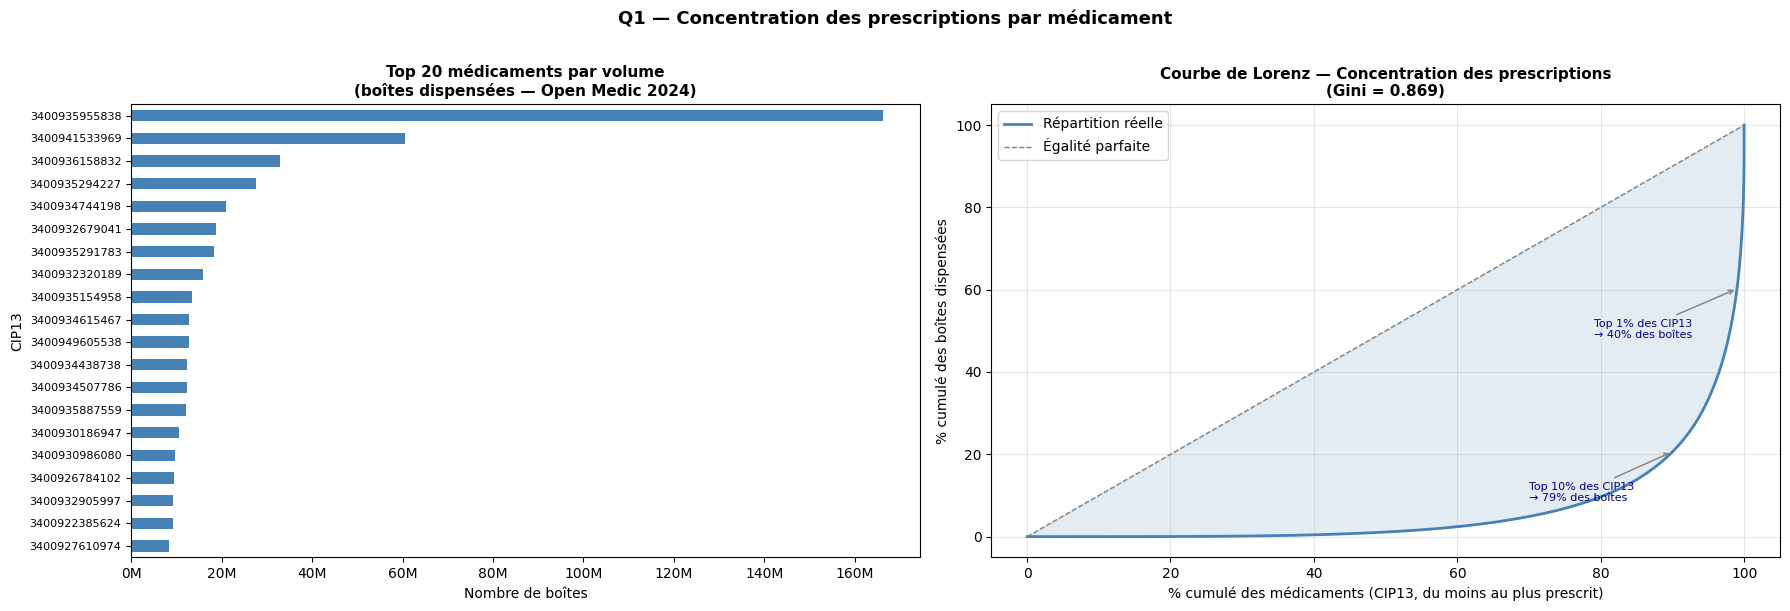

=== Q1 — Concentration des prescriptions (2024) ===

Médicaments distincts (CIP13) : 12,646
Total boîtes dispensées       : 2368 millions
Coefficient de Gini           : 0.869

Concentration par palier :
  Palier                         Nb CIP13   % boîtes
  ----------------------------------------------------
  Top  1% des CIP13                126      39.8%
  Top  5% des CIP13                632      66.6%
  Top 10% des CIP13              1,264      79.4%
  Top 20% des CIP13              2,529      90.3%
  Top 50% des CIP13              6,323      98.9%

  50% du volume atteint par 249 CIP13 (2.0% des codes)
  80% du volume atteint par 1310 CIP13 (10.4% des codes)

Top 10 médicaments par volume :
  CIP13                 Boîtes   % total
  ----------------------------------------
  3400935955838    166,162,738      7.0%
  3400941533969     60,537,669      2.6%
  3400936158832     32,850,384      1.4%
  3400935294227     27,494,203      1.2%
  3400934744198     20,930,394      0.9%
  3

In [12]:
top_cip_boxes = df.groupby(CIP_COL)[BOX_COL].sum().sort_values(ascending=False)

n_total     = len(top_cip_boxes)
boxes_total = top_cip_boxes.sum()

# Courbe de Lorenz
sorted_vals = top_cip_boxes.sort_values().values
cumul_labs  = np.arange(1, n_total + 1) / n_total * 100
cumul_boxes = np.cumsum(sorted_vals) / sorted_vals.sum() * 100

# Coefficient de Gini
n    = n_total
gini = (2 * np.sum(np.arange(1, n + 1) * sorted_vals) / (n * sorted_vals.sum())) - (n + 1) / n

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 20
top20 = top_cip_boxes.head(20)
top20.sort_values().plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title(f"Top 20 médicaments par volume\n(boîtes dispensées — Open Medic {YEAR})",
                  fontsize=11, fontweight="bold")
axes[0].set_xlabel("Nombre de boîtes")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
axes[0].set_yticklabels([str(l)[-13:] for l in top20.sort_values().index], fontsize=8)

# Courbe de Lorenz
axes[1].plot(cumul_labs, cumul_boxes, color="steelblue", linewidth=2, label="Répartition réelle")
axes[1].plot([0, 100], [0, 100], color="gray", linestyle="--", linewidth=1, label="Égalité parfaite")
axes[1].fill_between(cumul_labs, cumul_boxes, cumul_labs, alpha=0.15, color="steelblue")
axes[1].set_xlabel("% cumulé des médicaments (CIP13, du moins au plus prescrit)")
axes[1].set_ylabel("% cumulé des boîtes dispensées")
axes[1].set_title(f"Courbe de Lorenz — Concentration des prescriptions\n(Gini = {gini:.3f})",
                  fontsize=11, fontweight="bold")
axes[1].legend()
axes[1].grid(alpha=0.3)

for pct_labs in [10, 1]:
    n_labs  = max(1, int(pct_labs / 100 * n_total))
    pct_vol = top_cip_boxes.head(n_labs).sum() / boxes_total * 100
    x_pos = 100 - pct_labs
    y_pos = 100 - pct_vol
    axes[1].annotate(
        f"Top {pct_labs}% des CIP13\n→ {pct_vol:.0f}% des boîtes",
        xy=(x_pos, y_pos), xytext=(x_pos - 20, y_pos - 12),
        arrowprops={"arrowstyle": "->", "color": "gray"}, fontsize=8, color="darkblue"
    )

plt.suptitle("Q1 — Concentration des prescriptions par médicament", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# --- Résultats détaillés ---
print(f"=== Q1 — Concentration des prescriptions ({YEAR}) ===")
print(f"\nMédicaments distincts (CIP13) : {n_total:,}")
print(f"Total boîtes dispensées       : {boxes_total/1e6:.0f} millions")
print(f"Coefficient de Gini           : {gini:.3f}")

print(f"\nConcentration par palier :")
print(f"  {'Palier':<30} {'Nb CIP13':>8}  {'% boîtes':>9}")
print(f"  {'-'*52}")
for pct in [1, 5, 10, 20, 50]:
    n_k   = max(1, int(pct / 100 * n_total))
    share = top_cip_boxes.head(n_k).sum() / boxes_total * 100
    print(f"  Top {pct:>2}% des CIP13           {n_k:>8,}  {share:>8.1f}%")

cumul = top_cip_boxes.cumsum()
n50 = int((cumul <= boxes_total * 0.50).sum()) + 1
n80 = int((cumul <= boxes_total * 0.80).sum()) + 1
print(f"\n  50% du volume atteint par {n50} CIP13 ({n50/n_total*100:.1f}% des codes)")
print(f"  80% du volume atteint par {n80} CIP13 ({n80/n_total*100:.1f}% des codes)")

print(f"\nTop 10 médicaments par volume :")
print(f"  {'CIP13':<15} {'Boîtes':>12}  {'% total':>8}")
print(f"  {'-'*40}")
for cip, v in top_cip_boxes.head(10).items():
    print(f"  {str(cip):<15} {int(v):>12,}  {v/boxes_total*100:>7.1f}%")

#### Top 20 — nom commercial vs molécule (double vue)

**Par nom commercial** : `CIP13` est la clé de jointure vers la BDPM — `CIS_CIP_bdpm.txt` relie chaque CIP13 à un code CIS, puis `CIS_bdpm.txt` fournit la dénomination commerciale (ex. DOLIPRANE, GLUCOPHAGE).

**Par molécule** : la colonne `L_ATC5_` du fichier Open Medic contient directement la substance chimique (ex. paracétamol, metformine). **Pas besoin de la BDPM pour cette vue** — la jointure n'est utile que pour retrouver le nom de marque.

In [ ]:
# ── BDPM : CIP13 → nom commercial ──────────────────────────────────────────
BDPM_DIR = Path("../../data/raw/bdpm")

cip_ref = pd.read_csv(
    BDPM_DIR / "CIS_CIP_bdpm.txt",
    sep="\t", header=None, encoding="latin-1", low_memory=False,
    usecols=[0, 2, 6],
    names=["code_cis", "libelle_presentation", "code_cip13"],
    dtype=str,
)
cis_ref = pd.read_csv(
    BDPM_DIR / "CIS_bdpm.txt",
    sep="\t", header=None, encoding="latin-1", low_memory=False,
    usecols=[0, 1, 2],
    names=["code_cis", "denomination_specialite", "forme_pharmaceutique"],
    dtype=str,
)
drug_ref = (
    cip_ref
    .merge(cis_ref, on="code_cis", how="left")
    [["code_cip13", "denomination_specialite", "forme_pharmaceutique"]]
    .assign(code_cip13=lambda d: d["code_cip13"].str.strip().str.zfill(13))
    .drop_duplicates("code_cip13")
)

# ── Vue 1 : top 20 par nom commercial (jointure BDPM) ──────────────────────
top20_cip = (
    top_cip_boxes.head(20)
    .reset_index()
    .rename(columns={CIP_COL: "code_cip13", BOX_COL: "boites"})
)
top20_cip["code_cip13"] = top20_cip["code_cip13"].astype(str).str.strip().str.zfill(13)
top20_cip = top20_cip.merge(drug_ref, on="code_cip13", how="left")
top20_cip["label"] = top20_cip.apply(
    lambda r: str(r["denomination_specialite"])[:45]
              if pd.notna(r["denomination_specialite"]) else f"CIP {r['code_cip13']}",
    axis=1,
)
n_matched = top20_cip["denomination_specialite"].notna().sum()
print(f"Couverture BDPM : {n_matched}/20 CIP13 résolus en noms commerciaux\n")

# ── Vue 2 : top 20 par molécule (L_ATC5 — direct Open Medic, sans BDPM) ────
ATC5_COL_Q1 = find_col(df, ["L_ATC5", "ATC5", "atc5"])
if ATC5_COL_Q1:
    top20_mol = (
        df[df[ATC5_COL_Q1].notna()]
        .groupby(ATC5_COL_Q1)[BOX_COL]
        .sum()
        .sort_values(ascending=False)
        .head(20)
    )
    print(f"Top molécule : {str(top20_mol.index[0]).title()} — {top20_mol.iloc[0]/1e6:.0f}M boîtes")
else:
    top20_mol = None
    print("⚠  L_ATC5 introuvable — vue molécule désactivée")

# ── Graphiques côte à côte ─────────────────────────────────────────────────
ncols = 2 if top20_mol is not None else 1
fig, axes = plt.subplots(1, ncols, figsize=(18, 7))
if ncols == 1:
    axes = [axes]

# Panneau gauche : noms commerciaux
top20_cip_s = top20_cip.sort_values("boites")
axes[0].barh(range(len(top20_cip_s)), top20_cip_s["boites"] / 1e6,
             color="#3498db", alpha=0.85)
axes[0].set_yticks(range(len(top20_cip_s)))
axes[0].set_yticklabels([l[:48] for l in top20_cip_s["label"].tolist()], fontsize=8)
axes[0].set_xlabel("Boîtes dispensées (millions)")
axes[0].set_title(
    f"Par nom commercial (BDPM)\nOpen Medic {YEAR}",
    fontsize=10, fontweight="bold"
)

# Panneau droit : molécules (ATC5, sans BDPM)
if top20_mol is not None:
    mol_vals   = top20_mol.values / 1e6
    mol_labels = [str(s).title()[:45] for s in top20_mol.index]
    sorted_idx = np.argsort(mol_vals)
    axes[1].barh(range(len(mol_vals)), mol_vals[sorted_idx],
                 color="#e67e22", alpha=0.85)
    axes[1].set_yticks(range(len(mol_vals)))
    axes[1].set_yticklabels([mol_labels[i] for i in sorted_idx], fontsize=8)
    axes[1].set_xlabel("Boîtes dispensées (millions)")
    axes[1].set_title(
        f"Par molécule — substance chimique ATC5 (sans BDPM)\nOpen Medic {YEAR}",
        fontsize=10, fontweight="bold"
    )

plt.suptitle(
    f"Q1 — Top 20 médicaments par nom commercial vs par molécule — {YEAR}",
    fontsize=12, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

# ── Tableau comparatif ─────────────────────────────────────────────────────
if top20_mol is not None:
    tbl = pd.DataFrame({
        "Nom commercial (BDPM)":        top20_cip["label"].values,
        "Boîtes/nom (M)":               (top20_cip["boites"].values / 1e6).round(1),
        "Molécule (ATC5 — sans BDPM)":  [str(s).title() for s in top20_mol.index],
        "Boîtes/mol. (M)":              (top20_mol.values / 1e6).round(1),
    }, index=range(1, 21))
    tbl.index.name = "Rang"
    display(tbl)

### Q2 — Comment les dépenses de remboursement se répartissent-elles par classe thérapeutique ?

La classification ATC est la valeur ajoutée principale d'Open Medic par rapport à la BDPM : elle permet
de segmenter le marché par système anatomique et aire thérapeutique. L'analyse met en évidence une
dissociation fondamentale entre **volumes** (les classes qui prescrivent le plus) et **coûts** (les
classes qui consomment le plus de budget Assurance Maladie). Cette dissociation est au cœur des enjeux
de régulation pharmaceutique.

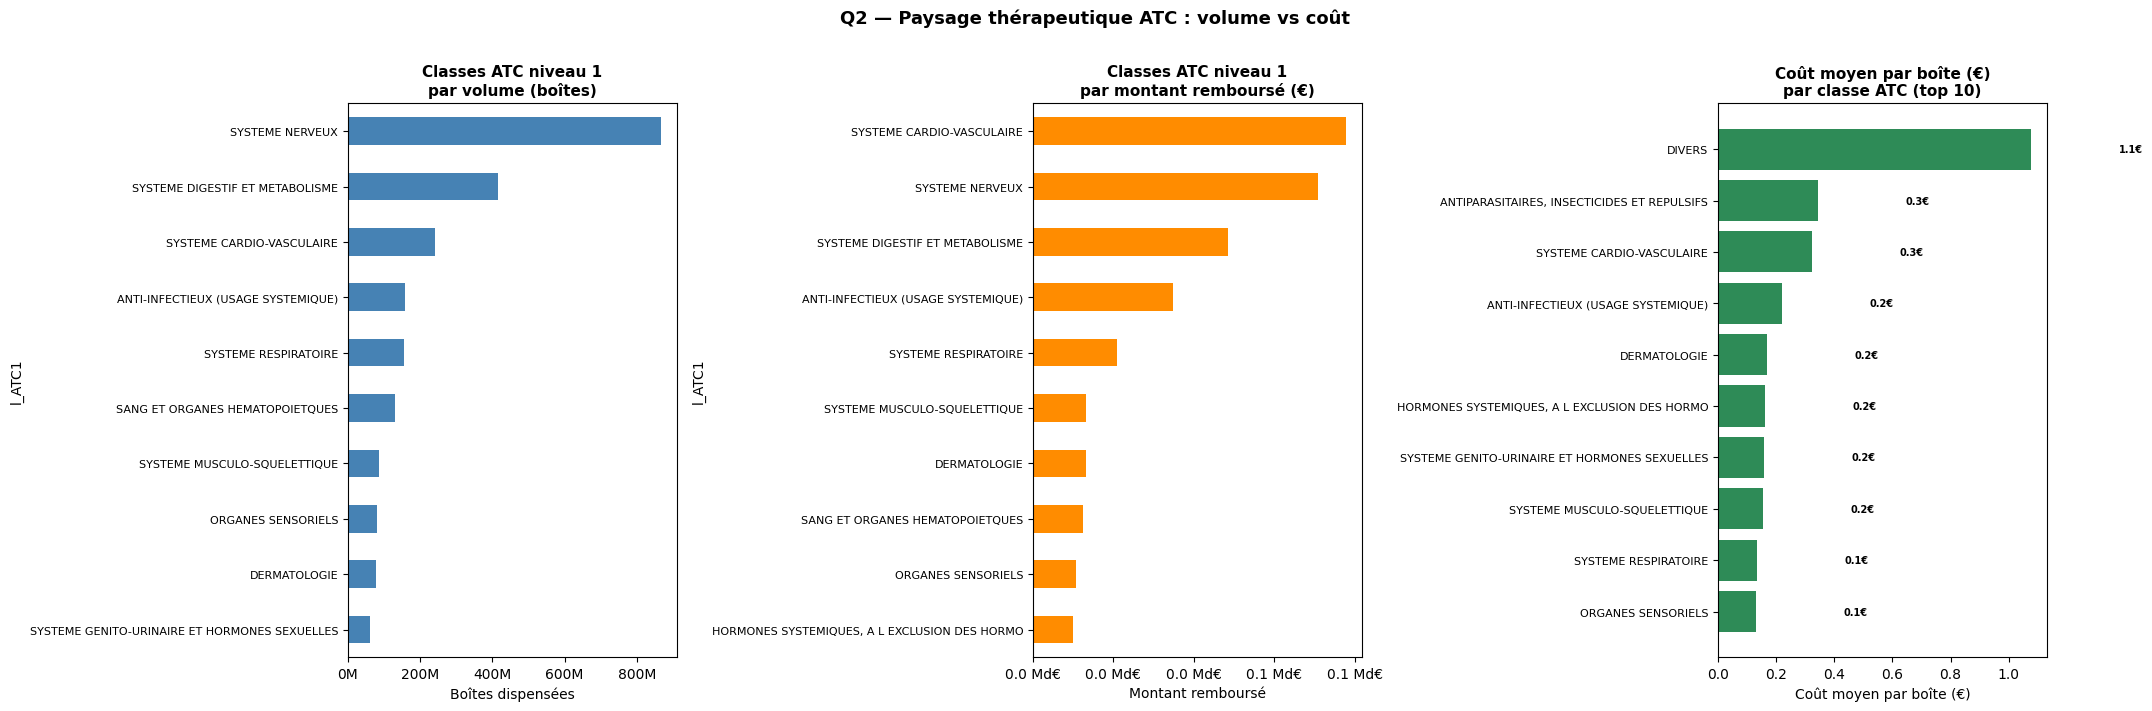

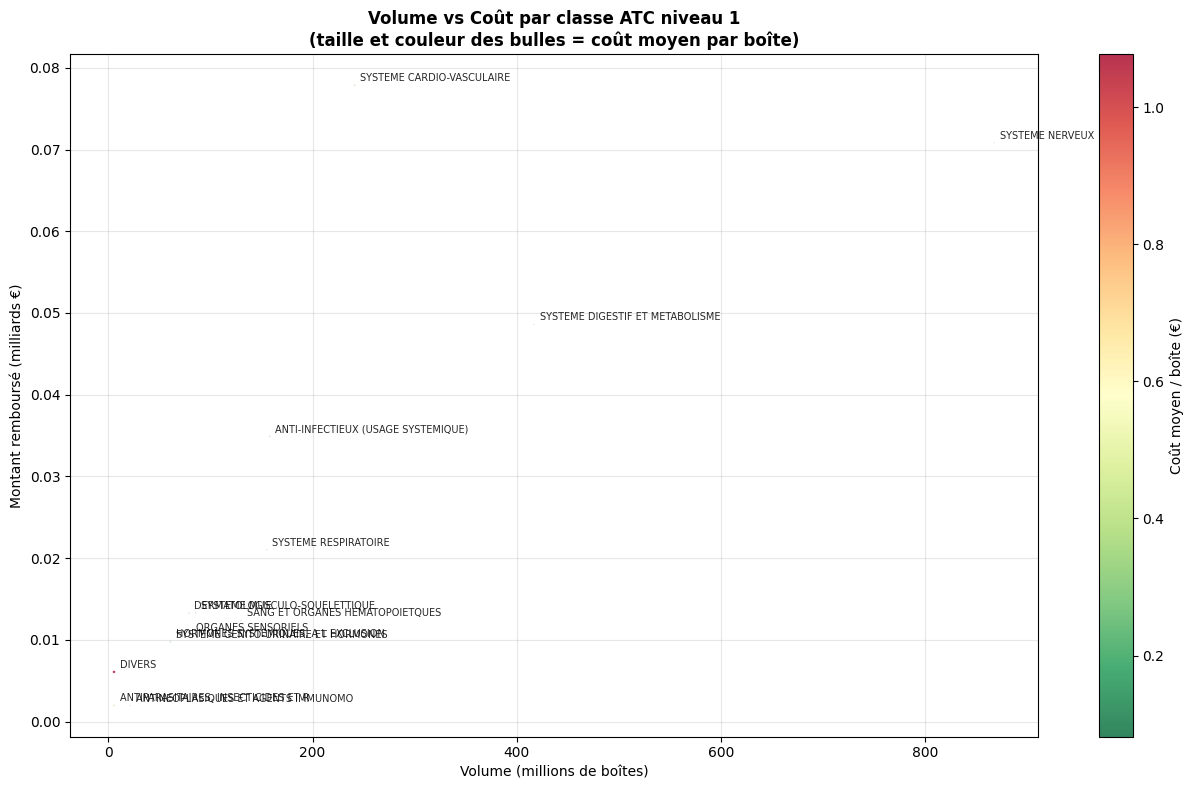

=== Q2 — Paysage thérapeutique ATC (2024) ===

Classe ATC                                         Boîtes (M)   % vol   Remb. (M€)   % coût    €/boîte
  ----------------------------------------------------------------------------------------------------
  SYSTEME NERVEUX                                          867   36.6%          71    21.3%      0.08€
  SYSTEME DIGESTIF ET METABOLISME                          417   17.6%          49    14.6%      0.12€
  SYSTEME CARDIO-VASCULAIRE                                241   10.2%          78    23.4%      0.32€
  ANTI-INFECTIEUX (USAGE SYSTEMIQUE)                       158    6.7%          35    10.5%      0.22€
  SYSTEME RESPIRATOIRE                                     155    6.6%          21     6.3%      0.14€
  SANG ET ORGANES HEMATOPOIETQUES                          130    5.5%          12     3.7%      0.10€
  SYSTEME MUSCULO-SQUELETTIQUE                              86    3.6%          13     4.0%      0.15€
  ORGANES SENSORIELS      

In [13]:
assert ATC1_COL, f"Colonne ATC niveau 1 introuvable — colonnes disponibles : {list(df.columns)}"
assert REM_COL,  f"Colonne montant remboursé introuvable"

# Agrégation par classe ATC niveau 1
atc1 = df.groupby(ATC1_COL).agg(
    boites=       (BOX_COL, "sum"),
    remboursement=(REM_COL, "sum"),
).dropna()
atc1["cout_par_boite"] = atc1["remboursement"] / atc1["boites"]
atc1["pct_volume"]     = atc1["boites"] / atc1["boites"].sum() * 100
atc1["pct_couts"]      = atc1["remboursement"] / atc1["remboursement"].sum() * 100
atc1 = atc1.sort_values("boites", ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

top_vol = atc1["boites"].head(10).sort_values()
top_vol.plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title("Classes ATC niveau 1\npar volume (boîtes)", fontsize=11, fontweight="bold")
axes[0].set_xlabel("Boîtes dispensées")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
axes[0].set_yticklabels([str(l)[:45] for l in top_vol.index], fontsize=8)

top_rem = atc1["remboursement"].sort_values().tail(10).sort_values()
top_rem.plot.barh(ax=axes[1], color="darkorange")
axes[1].set_title("Classes ATC niveau 1\npar montant remboursé (€)", fontsize=11, fontweight="bold")
axes[1].set_xlabel("Montant remboursé")
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e9:.1f} Md€"))
axes[1].set_yticklabels([str(l)[:45] for l in top_rem.index], fontsize=8)

top_cpb = atc1["cout_par_boite"].sort_values().tail(10).sort_values()
bars = axes[2].barh(range(len(top_cpb)), top_cpb.values, color="seagreen")
axes[2].set_yticks(range(len(top_cpb)))
axes[2].set_yticklabels([str(l)[:45] for l in top_cpb.index], fontsize=8)
axes[2].set_xlabel("Coût moyen par boîte (€)")
axes[2].set_title("Coût moyen par boîte (€)\npar classe ATC (top 10)", fontsize=11, fontweight="bold")
for bar, v in zip(bars, top_cpb.values):
    axes[2].text(v + 0.3, bar.get_y() + bar.get_height() / 2,
                 f"{v:.1f}€", va="center", fontsize=7, fontweight="bold")

plt.suptitle("Q2 — Paysage thérapeutique ATC : volume vs coût", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# Bubble chart: volume vs remboursement
fig, ax = plt.subplots(figsize=(13, 8))
sc = ax.scatter(
    atc1["boites"] / 1e6,
    atc1["remboursement"] / 1e9,
    s=atc1["cout_par_boite"] * 4,
    c=atc1["cout_par_boite"],
    cmap="RdYlGn_r", alpha=0.8, edgecolors="white", linewidth=0.5
)
for atc_name, row in atc1.iterrows():
    ax.annotate(str(atc_name)[:35], (row["boites"] / 1e6, row["remboursement"] / 1e9),
                fontsize=7, alpha=0.85, xytext=(4, 3), textcoords="offset points")
plt.colorbar(sc, ax=ax, label="Coût moyen / boîte (€)")
ax.set_xlabel("Volume (millions de boîtes)")
ax.set_ylabel("Montant remboursé (milliards €)")
ax.set_title("Volume vs Coût par classe ATC niveau 1\n(taille et couleur des bulles = coût moyen par boîte)",
             fontsize=12, fontweight="bold")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Résultats détaillés ---
print(f"=== Q2 — Paysage thérapeutique ATC ({YEAR}) ===")
print(f"\n{'Classe ATC':<50} {'Boîtes (M)':>10}  {'% vol':>6}  {'Remb. (M€)':>11}  {'% coût':>7}  {'€/boîte':>9}")
print(f"  {'-'*100}")
for atc_name, row in atc1.head(12).iterrows():
    label = str(atc_name)[:48]
    print(f"  {label:<50} {row['boites']/1e6:>9.0f}  {row['pct_volume']:>5.1f}%  "
          f"{row['remboursement']/1e6:>10.0f}  {row['pct_couts']:>6.1f}%  {row['cout_par_boite']:>8.2f}€")

print(f"\nDissociation volume/coût — les extrêmes :")
cheapest  = atc1.nsmallest(3,  "cout_par_boite")
costliest = atc1.nlargest(3, "cout_par_boite")
print(f"\n  Classes les moins chères par boîte :")
for a, r in cheapest.iterrows():
    print(f"    {str(a)[:45]:<45} {r['cout_par_boite']:.2f} €/boîte")
print(f"\n  Classes les plus chères par boîte :")
for a, r in costliest.iterrows():
    print(f"    {str(a)[:45]:<45} {r['cout_par_boite']:.2f} €/boîte")

### Q3 — La prescription révèle-t-elle des inégalités démographiques ?

Open Medic ventile chaque ligne par tranche d'âge (trois classes : 0-19 ans, 20-59 ans, 60 ans et plus)
et par sexe — une dimension absente de la BDPM. Cette granularité permet de répondre à une question
clé : **qui** consomme réellement les médicaments ? La répartition observée est loin d'être uniforme :
certaines classes thérapeutiques sont quasi-exclusivement consommées par des patients âgés, d'autres
présentent un fort déséquilibre hommes/femmes.

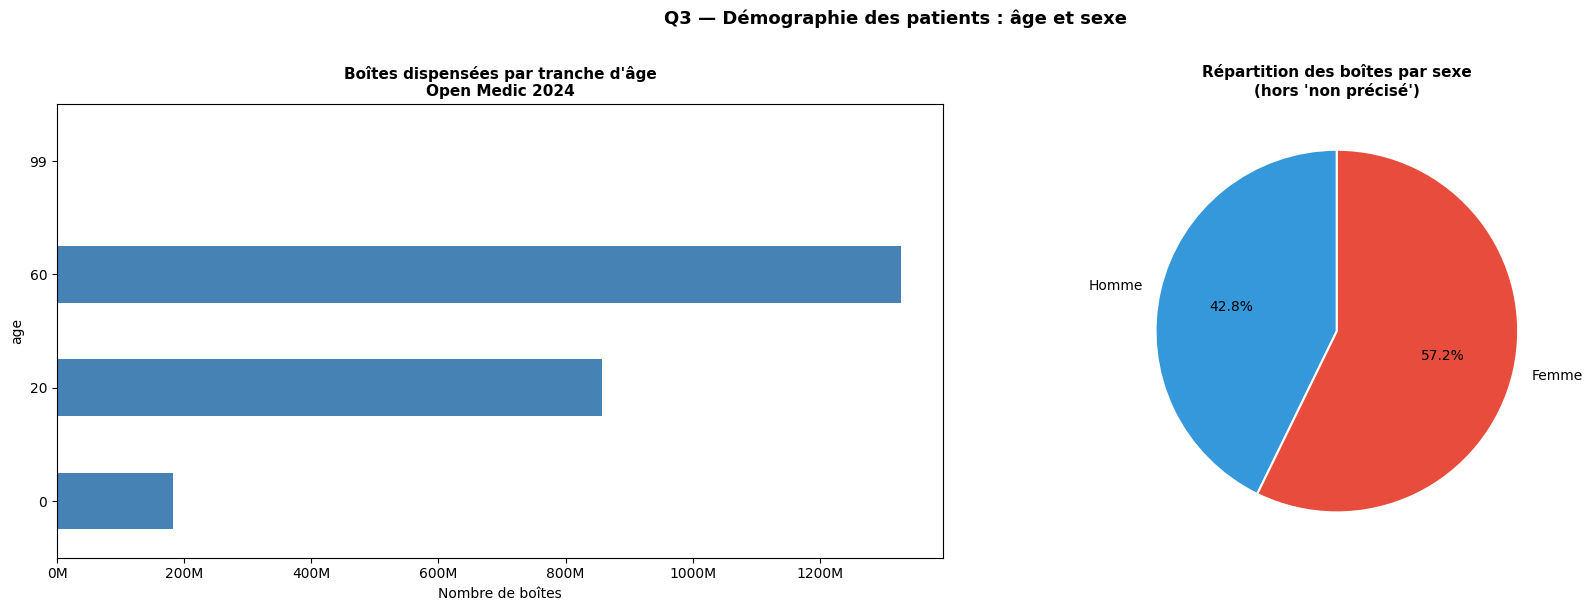

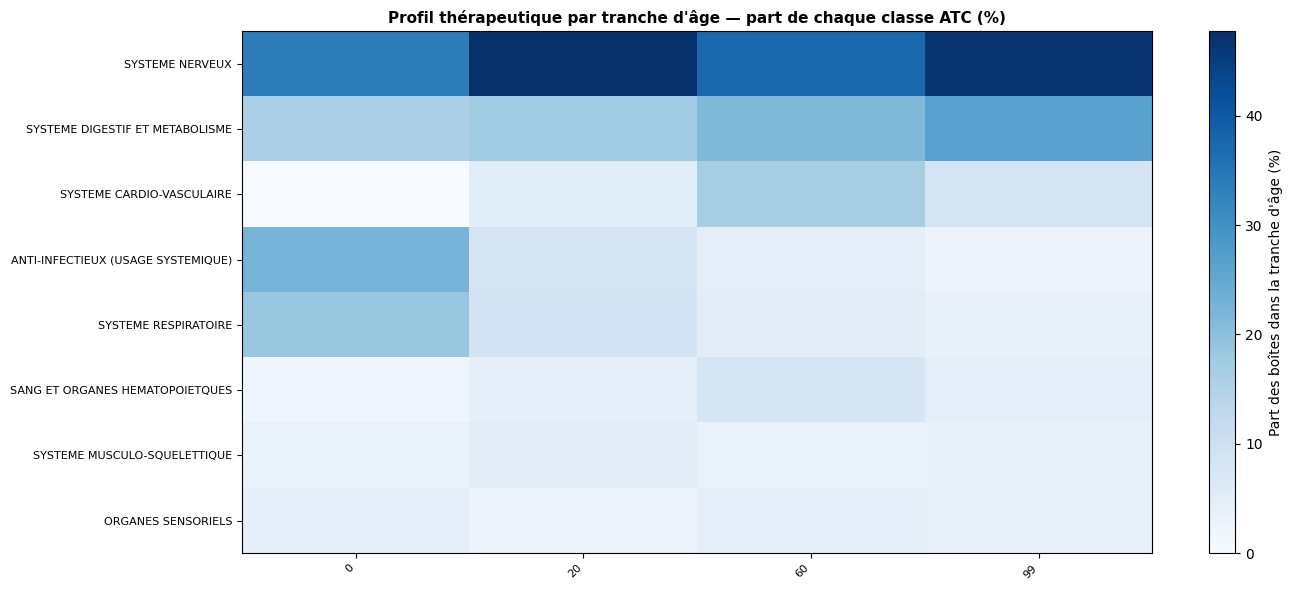

=== Q3 — Démographie des patients (2024) ===

Répartition par âge (codes : 0=0-19 ans, 20=20-59 ans, 60=60 ans et plus, 99=inconnu) :
  Tranche               Boîtes (M)   % total
  --------------------------------------------
    0                         183      7.7%
    20                        856     36.2%
  ★ 60                       1328     56.1%
    99                          1      0.0%

  → 60 ans et plus : 1328M boîtes (56.1% du total)

Répartition par sexe :
  Homme                 1013M boîtes  (42.8%)
  Femme                 1355M boîtes  (57.2%)
  Non précisé              0M boîtes  (0.0%)

Top 8 classes ATC — index de féminité (% boîtes chez les femmes) :
  Classe ATC                                           % Femme    % Homme
  ------------------------------------------------------------------------
  SYSTEME NERVEUX                                        59.4%      40.6%
  ORGANES SENSORIELS                                     58.6%      41.4%
  SYSTEME DIGESTIF E

In [14]:
assert AGE_COL, f"Colonne âge introuvable — colonnes dispo : {list(df.columns)}"
assert SEX_COL, f"Colonne sexe introuvable — colonnes dispo : {list(df.columns)}"

# Codes AGE : 0=0-19 ans, 20=20-59 ans, 60=60 ans et plus, 99=inconnu
age_boxes = df.groupby(AGE_COL)[BOX_COL].sum()

def age_sort_key(label):
    m = re.search(r'\d+', str(label))
    return int(m.group()) if m else 999

age_boxes = age_boxes.reindex(sorted(age_boxes.index, key=age_sort_key))

# --- Sexe ---
sex_boxes = df.groupby(SEX_COL)[BOX_COL].sum()
sex_labels = {1: "Homme", 2: "Femme", 9: "Non précisé"}
sex_boxes.index = sex_boxes.index.map(lambda x: sex_labels.get(int(x) if str(x).isdigit() else x, str(x)))
sex_hf = sex_boxes[[l for l in ["Homme", "Femme"] if l in sex_boxes.index]]

# --- Graphiques ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

age_boxes.plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title(f"Boîtes dispensées par tranche d'âge\nOpen Medic {YEAR}", fontsize=11, fontweight="bold")
axes[0].set_xlabel("Nombre de boîtes")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))

colors_sex = ["#3498db", "#e74c3c"]
if len(sex_hf) >= 2:
    axes[1].pie(
        sex_hf.values, labels=sex_hf.index, autopct="%1.1f%%",
        colors=colors_sex[:len(sex_hf)], startangle=90,
        wedgeprops={"edgecolor": "white", "linewidth": 1.5}
    )
axes[1].set_title(f"Répartition des boîtes par sexe\n(hors 'non précisé')", fontsize=11, fontweight="bold")
axes[1].set_ylabel("")

plt.suptitle("Q3 — Démographie des patients : âge et sexe", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# --- Heatmap âge × ATC ---
if ATC1_COL:
    age_atc = df.groupby([AGE_COL, ATC1_COL])[BOX_COL].sum().unstack(fill_value=0)
    top_atc_cols = age_atc.sum().nlargest(8).index
    age_atc_top  = age_atc[top_atc_cols]
    age_atc_top  = age_atc_top.reindex(sorted(age_atc_top.index, key=age_sort_key))
    age_atc_pct  = age_atc_top.div(age_atc_top.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(age_atc_pct.T.values, aspect="auto", cmap="Blues", vmin=0)
    ax.set_xticks(range(len(age_atc_pct.index)))
    ax.set_xticklabels(age_atc_pct.index, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(age_atc_pct.columns)))
    ax.set_yticklabels([str(c)[:50] for c in age_atc_pct.columns], fontsize=8)
    plt.colorbar(im, ax=ax, label="Part des boîtes dans la tranche d'âge (%)")
    ax.set_title("Profil thérapeutique par tranche d'âge — part de chaque classe ATC (%)",
                 fontsize=11, fontweight="bold")
    plt.tight_layout()
    plt.show()

# --- Résultats détaillés ---
print(f"=== Q3 — Démographie des patients ({YEAR}) ===")

total_b = age_boxes.sum()
# Code AGE = 60 correspond à "60 ans et plus"
age_60p_val = age_boxes[[a for a in age_boxes.index if age_sort_key(a) == 60]].sum()

print(f"\nRépartition par âge (codes : 0=0-19 ans, 20=20-59 ans, 60=60 ans et plus, 99=inconnu) :")
print(f"  {'Tranche':<20} {'Boîtes (M)':>11}  {'% total':>8}")
print(f"  {'-'*44}")
for age_label, v in age_boxes.items():
    is_senior = "★" if age_sort_key(age_label) == 60 else " "
    print(f"  {is_senior} {str(age_label):<18} {v/1e6:>10.0f}  {v/total_b*100:>7.1f}%")
print(f"\n  → 60 ans et plus : {age_60p_val/1e6:.0f}M boîtes ({age_60p_val/total_b*100:.1f}% du total)")

print(f"\nRépartition par sexe :")
for s, v in sex_boxes.items():
    print(f"  {str(s):<15} {v/1e6:>10.0f}M boîtes  ({v/sex_boxes.sum()*100:.1f}%)")

# Profil ATC par sexe
if ATC1_COL:
    print(f"\nTop 8 classes ATC — index de féminité (% boîtes chez les femmes) :")
    sex_atc = df[df[SEX_COL].astype(str).isin(["1", "2"])].copy()
    sex_atc["sexe_label"] = sex_atc[SEX_COL].astype(str).map({"1": "Homme", "2": "Femme"})
    atc_sex = sex_atc.groupby([ATC1_COL, "sexe_label"])[BOX_COL].sum().unstack(fill_value=0)
    if "Femme" in atc_sex.columns and "Homme" in atc_sex.columns:
        atc_sex["total"]     = atc_sex["Femme"] + atc_sex["Homme"]
        atc_sex["pct_femme"] = atc_sex["Femme"] / atc_sex["total"] * 100
        top_atc_by_vol = atc_sex.nlargest(8, "total")
        print(f"  {'Classe ATC':<50} {'% Femme':>9}  {'% Homme':>9}")
        print(f"  {'-'*72}")
        for atc_n, row in top_atc_by_vol.sort_values("pct_femme", ascending=False).iterrows():
            print(f"  {str(atc_n)[:48]:<50} {row['pct_femme']:>8.1f}%  {100-row['pct_femme']:>8.1f}%")

---
## Comparaison multi-années (optionnel — nécessite de télécharger d'autres millésimes)

Open Medic couvre 2014-2024 : dix ans de prescription permettent d'analyser les tendances
structurelles (montée des biologiques, baisse des antibiotiques, hausse des traitements
du diabète de type 2...). Décommenter la cellule suivante pour télécharger tous les millésimes.

In [15]:
# Décommenter pour télécharger et comparer tous les millésimes disponibles (2014-2024)
# for year in range(2014, 2025):
#     dest_y = RAW_DIR / f"open_medic_{year}.csv"
#     if dest_y.exists():
#         print(f"  [skip] {year}")
#         continue
#     print(f"  Downloading {year}...", end=" ")
#     with httpx.stream("GET", open_medic_url(year), follow_redirects=True, timeout=600) as r:
#         r.raise_for_status()
#         with open(dest_y, "wb") as f:
#             for chunk in r.iter_bytes(65536):
#                 f.write(chunk)
#     print(f"{dest_y.stat().st_size/1e6:.0f} MB")
#
# dfs = []
# for year in range(2014, 2025):
#     p = RAW_DIR / f"open_medic_{year}.csv"
#     if not p.exists():
#         continue
#     d = pd.read_csv(p, sep=";", encoding="latin-1", low_memory=False)
#     d.columns = d.columns.str.strip()
#     bc = find_col(d, ['boite', 'BOITES'])
#     rc = find_col(d, ['REM'])
#     if bc and rc:
#         for col in [bc, rc]:
#             d[col] = pd.to_numeric(d[col].astype(str).str.replace(',', '.'), errors='coerce')
#         dfs.append({"year": year, "boites": d[bc].sum(), "remboursement": d[rc].sum()})
#
# if dfs:
#     trend = pd.DataFrame(dfs).set_index("year")
#     fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#     trend["boites"].div(1e9).plot.bar(ax=axes[0], color="steelblue")
#     axes[0].set_title("Total boîtes dispensées par année (Mds)")
#     axes[0].set_ylabel("Milliards de boîtes")
#     trend["remboursement"].div(1e9).plot.bar(ax=axes[1], color="darkorange")
#     axes[1].set_title("Total remboursé par année (Mds €)")
#     axes[1].set_ylabel("Milliards €")
#     plt.tight_layout()
#     plt.show()
print("Cellule multi-années — décommenter pour exécuter.")

Cellule multi-années — décommenter pour exécuter.


---
## Q4 — Pénétration des génériques par classe thérapeutique

Open Medic encode si chaque boîte dispensée était un générique (`TOP_GEN=1`) ou un original
(`TOP_GEN=0`), et si la molécule appartient à un groupe de génériques (`GEN_NUM>0`).
Ces deux indicateurs permettent de mesurer la substitution effective et d'estimer combien
de boîtes originales auraient pu être substituées — proxy direct du potentiel d'économies
pour l'Assurance Maladie.

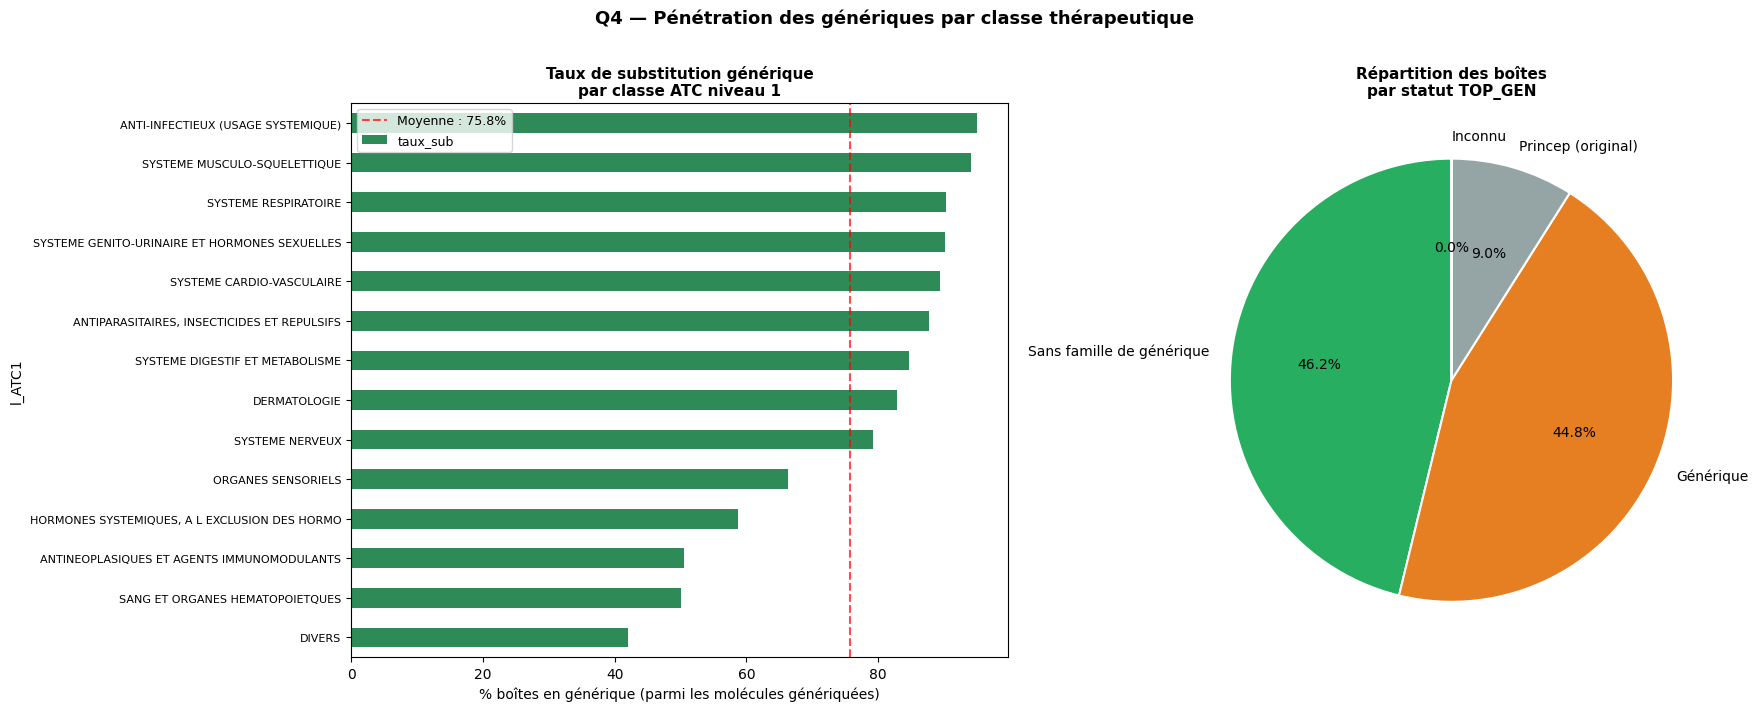

=== Q4 — Pénétration des génériques (2024) ===

  Encodage TOP_GEN (depuis 2022) :
    0 = pas dans une famille de générique (aucun générique existant)
    1 = Générique
    4 = Princep (original dont il existe un générique)
    9 = Inconnu

  Statut                         Boîtes (M)   % boîtes   Remb. (M€)   % coût
  ---------------------------------------------------------------------------
  Sans famille de générique           1094      46.2%          89    26.7%
  Générique                           1062      44.8%         209    62.9%
  Princep (original)                   212       9.0%          35    10.4%
  Inconnu                                0       0.0%           0     0.0%

  Taux de substitution (génériques / [génériques + princeps]) par classe ATC :
  Classe ATC                                          Taux sub.   Marché générique (M boîtes)
  --------------------------------------------------------------------------------------------
  ANTI-INFECTIEUX (USAGE SYSTEMIQU

In [16]:
assert GEN_COL,    f"TOP_GEN introuvable — colonnes : {list(df.columns)}"
assert GENNUM_COL, f"GEN_NUM introuvable — colonnes : {list(df.columns)}"

# TOP_GEN (depuis 2022) :
#   0 = pas dans une famille de générique (pas de générique disponible)
#   1 = Générique
#   4 = Princep (original dans une famille qui a des génériques)
#   9 = Inconnu
# NB : pour 2014-2021, l'encodage était différent (G/R/S/9/0)
GEN_MAP = {0: "Sans famille de générique", 1: "Générique", 4: "Princep (original)", 9: "Inconnu"}
df["_gen_label"] = df[GEN_COL].map(GEN_MAP).fillna("Code " + df[GEN_COL].astype(str))

# ── Globalement ──
g_stats = df.groupby("_gen_label").agg(
    boites        =(BOX_COL, "sum"),
    remboursement =(REM_COL, "sum"),
).dropna().reindex([GEN_MAP[k] for k in sorted(GEN_MAP) if GEN_MAP[k] in df["_gen_label"].unique()])
g_stats["pct_boites"] = g_stats["boites"] / g_stats["boites"].sum() * 100
g_stats["pct_rem"]    = g_stats["remboursement"] / g_stats["remboursement"].sum() * 100

# ── Taux de substitution par classe ATC niveau 1 ──
# Générique + Princep = molécules avec famille générique (GEN_NUM > 0)
# Taux de substitution = Générique / (Générique + Princep)
gen_atc = df.groupby([ATC1_COL, GEN_COL])[BOX_COL].sum().unstack(fill_value=0)
gen_atc.columns = [GEN_MAP.get(int(c) if str(c).isdigit() else c, str(c)) for c in gen_atc.columns]
gen_atc["total"] = gen_atc.sum(axis=1)
gen_col = "Générique"
pri_col = "Princep (original)"
if gen_col in gen_atc.columns and pri_col in gen_atc.columns:
    gen_atc["marche_generique"] = gen_atc[gen_col] + gen_atc[pri_col]
    gen_atc["taux_sub"] = gen_atc[gen_col] / gen_atc["marche_generique"].replace(0, float("nan")) * 100
    gen_atc = gen_atc.sort_values("taux_sub", ascending=False)
elif gen_col in gen_atc.columns:
    gen_atc["taux_sub"] = gen_atc[gen_col] / gen_atc["total"] * 100
    gen_atc = gen_atc.sort_values("taux_sub", ascending=False)

# ── Substitution potentielle : boîtes prescrites en Princep ──
df["_gennum"]       = pd.to_numeric(df[GENNUM_COL], errors="coerce").fillna(0)
df["_is_princep"]   = df[GEN_COL] == 4   # original avec générique dispo
df["_is_generic"]   = df[GEN_COL] == 1
n_with_gen_fam  = df[df["_gennum"] > 0][BOX_COL].sum()
n_princep       = df[df["_is_princep"]][BOX_COL].sum()
n_generic       = df[df["_is_generic"]][BOX_COL].sum()
n_total_boxes   = df[BOX_COL].sum()
taux_sub_global = n_generic / (n_generic + n_princep) * 100 if (n_generic + n_princep) > 0 else 0

# ── Graphiques ──
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

if "taux_sub" in gen_atc.columns:
    gen_atc["taux_sub"].dropna().sort_values().plot.barh(ax=axes[0], color="seagreen")
    axes[0].axvline(gen_atc["taux_sub"].dropna().mean(), color="red", linestyle="--", alpha=0.7,
                    label=f"Moyenne : {gen_atc['taux_sub'].dropna().mean():.1f}%")
    axes[0].set_title("Taux de substitution générique\npar classe ATC niveau 1",
                      fontsize=11, fontweight="bold")
    axes[0].set_xlabel("% boîtes en générique (parmi les molécules génériquées)")
    axes[0].legend(fontsize=9)
    axes[0].set_yticklabels(
        [str(l)[:45] for l in gen_atc["taux_sub"].dropna().sort_values().index], fontsize=8)

# Camembert global
pie_data = g_stats["boites"].dropna()
pie_data = pie_data[pie_data > 0]
axes[1].pie(pie_data, labels=pie_data.index,
            autopct="%1.1f%%", startangle=90,
            colors=["#27ae60", "#e67e22", "#95a5a6", "#c0392b"][:len(pie_data)],
            wedgeprops={"edgecolor": "white", "linewidth": 1.5})
axes[1].set_title("Répartition des boîtes\npar statut TOP_GEN", fontsize=11, fontweight="bold")

plt.suptitle("Q4 — Pénétration des génériques par classe thérapeutique",
             fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# ── Résultats ──
print(f"=== Q4 — Pénétration des génériques ({YEAR}) ===\n")
print(f"  Encodage TOP_GEN (depuis 2022) :")
print(f"    0 = pas dans une famille de générique (aucun générique existant)")
print(f"    1 = Générique")
print(f"    4 = Princep (original dont il existe un générique)")
print(f"    9 = Inconnu\n")
print(f"  {'Statut':<30} {'Boîtes (M)':>10}  {'% boîtes':>9}  {'Remb. (M€)':>11}  {'% coût':>7}")
print(f"  {'-'*75}")
for label, row in g_stats.iterrows():
    if pd.isna(row["boites"]):
        continue
    print(f"  {str(label):<30} {row['boites']/1e6:>9.0f}  {row['pct_boites']:>8.1f}%  "
          f"{row['remboursement']/1e6:>10.0f}  {row['pct_rem']:>6.1f}%")

print(f"\n  Taux de substitution (génériques / [génériques + princeps]) par classe ATC :")
print(f"  {'Classe ATC':<50} {'Taux sub.':>10}  {'Marché générique (M boîtes)':>28}")
print(f"  {'-'*92}")
if "taux_sub" in gen_atc.columns:
    for atc_n, row in gen_atc.dropna(subset=["taux_sub"]).sort_values("taux_sub", ascending=False).iterrows():
        print(f"  {str(atc_n)[:48]:<50} {row['taux_sub']:>9.1f}%  {row.get('marche_generique', row['total'])/1e6:>27.0f}")

print(f"\n  Synthèse du marché générique :")
print(f"    Boîtes en famille générique (GEN_NUM > 0) : {n_with_gen_fam/1e6:.0f}M ({n_with_gen_fam/n_total_boxes*100:.1f}% du total)")
print(f"    dont Génériques (TOP_GEN=1)               : {n_generic/1e6:.0f}M")
print(f"    dont Princeps  (TOP_GEN=4)                : {n_princep/1e6:.0f}M (non substituées)")
print(f"    Taux de substitution effectif              : {taux_sub_global:.1f}%")

---
## Q5 — Profil prescripteur par spécialité médicale

Open Medic ventile chaque ligne par code de spécialité du prescripteur (`PSP_SPE`).
Cette dimension permet d'identifier qui prescrit quoi : le médecin généraliste domine-t-il
par le volume, ou les spécialistes génèrent-ils l'essentiel de la dépense ?
La heatmap spécialité × classe ATC révèle les "signatures thérapeutiques" propres
à chaque spécialité — et permet de détecter les prescriptions atypiques (hors périmètre habituel).

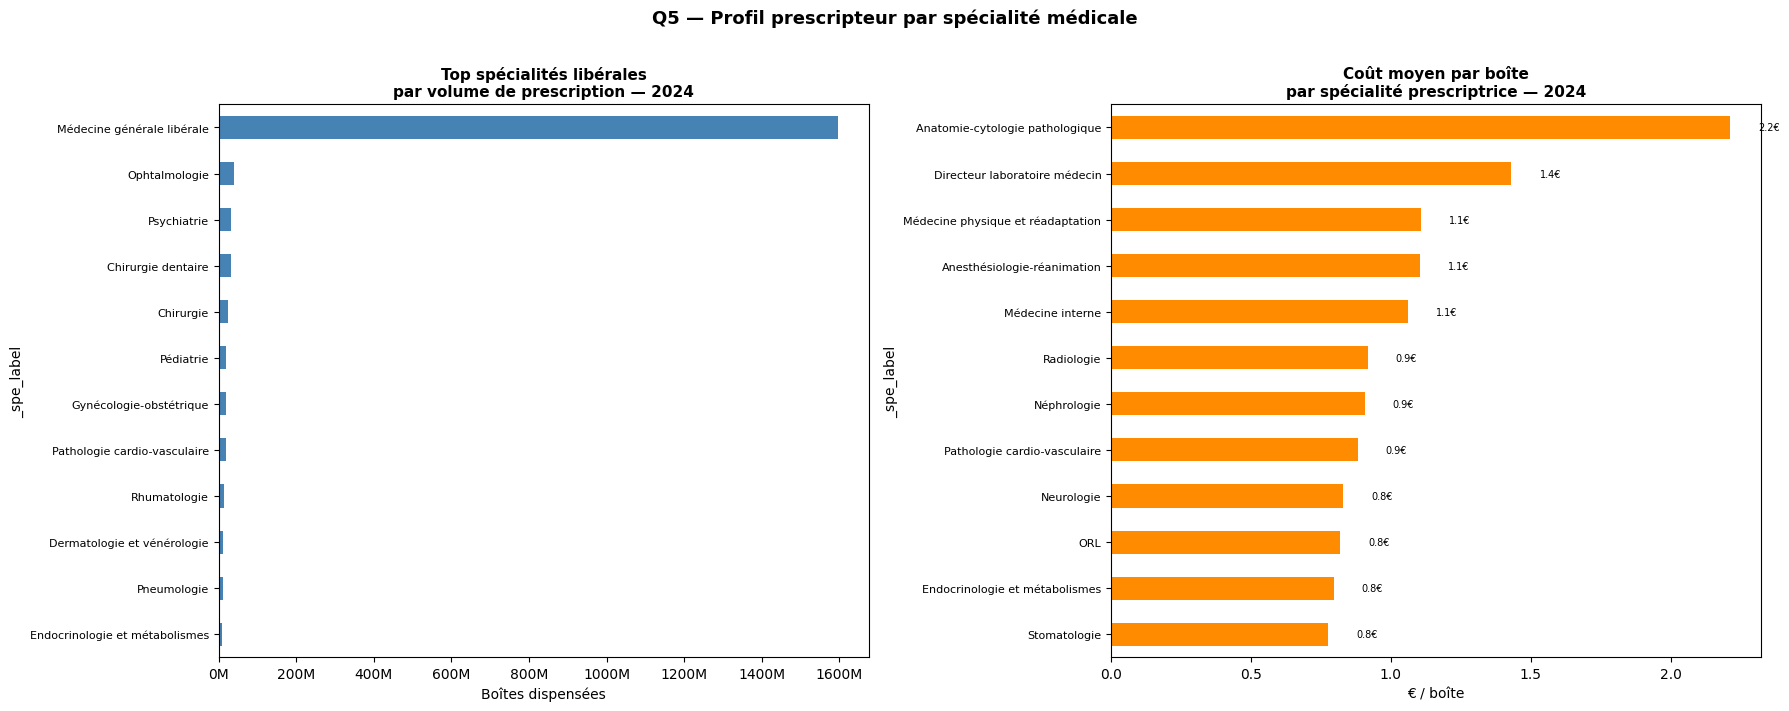

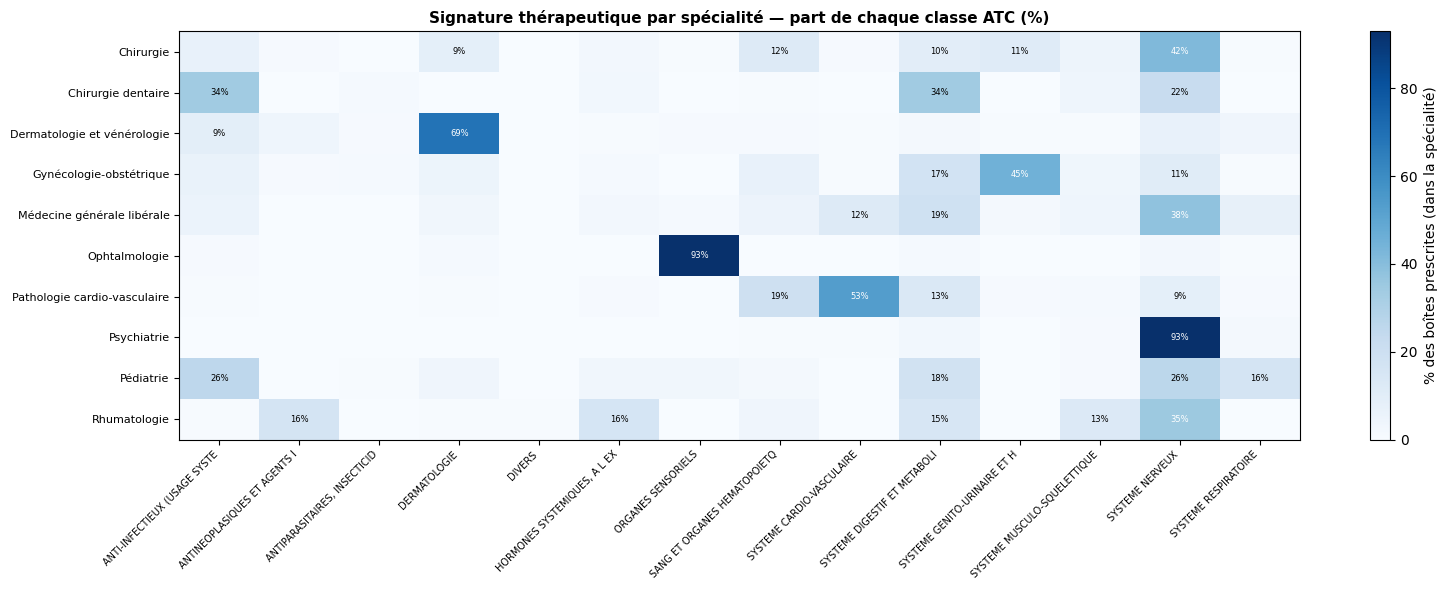

=== Q5 — Analyse par spécialité prescriptrice (2024) ===

  Spécialité                             Boîtes (M)   % vol.   Remb. (M€)   % coût    €/boîte
  ----------------------------------------------------------------------------------------
  Médecine générale libérale                  1596    67.4%          68    20.6%      0.04€
  Prescripteurs salariés (hôpitaux)            457    19.3%          73    21.9%      0.16€
  Ophtalmologie                                 40     1.7%           6     1.9%      0.15€
  Psychiatrie                                   33     1.4%          11     3.3%      0.33€
  Chirurgie dentaire                            32     1.4%           6     1.9%      0.20€
  Chirurgie                                     25     1.1%          12     3.6%      0.48€
  Valeur inconnue                               21     0.9%          62    18.7%      2.92€
  Autres prescripteurs de ville                 20     0.9%           8     2.3%      0.38€
  Pédiatrie          

In [17]:
assert PSP_SPE_COL, f"PSP_SPE introuvable — colonnes : {list(df.columns)}"

# Codes PSP_SPE — source : feuille PSP_SPE du fichier descriptif-variables CNAM
# Prescripteurs de ville (médecins et dentistes libéraux)
SPE_LABELS = {
    1:  "Médecine générale libérale",
    2:  "Anesthésiologie-réanimation",
    3:  "Pathologie cardio-vasculaire",
    4:  "Chirurgie",
    5:  "Dermatologie et vénérologie",
    6:  "Radiologie",
    7:  "Gynécologie-obstétrique",
    8:  "Gastro-entérologie et hépatologie",
    9:  "Médecine interne",
    11: "ORL",
    12: "Pédiatrie",
    13: "Pneumologie",
    14: "Rhumatologie",
    15: "Ophtalmologie",
    17: "Psychiatrie",
    18: "Stomatologie",
    19: "Chirurgie dentaire",
    31: "Médecine physique et réadaptation",
    32: "Neurologie",
    35: "Néphrologie",
    36: "Chirurgie dentaire (ODF)",
    37: "Anatomie-cytologie pathologique",
    38: "Directeur laboratoire médecin",
    42: "Endocrinologie et métabolismes",
    # Autres
    90: "Prescripteurs salariés (hôpitaux)",
    98: "Autres prescripteurs de ville",
    99: "Valeur inconnue",
}
df["_spe_label"] = (pd.to_numeric(df[PSP_SPE_COL], errors="coerce")
                    .map(SPE_LABELS)
                    .fillna("Code " + df[PSP_SPE_COL].astype(str).str.strip()))

spe_stats = df.groupby("_spe_label").agg(
    boites        =(BOX_COL, "sum"),
    remboursement =(REM_COL, "sum"),
).dropna().sort_values("boites", ascending=False)
spe_stats["cout_par_boite"] = spe_stats["remboursement"] / spe_stats["boites"]
spe_stats["pct_volume"]     = spe_stats["boites"] / spe_stats["boites"].sum() * 100
spe_stats["pct_couts"]      = spe_stats["remboursement"] / spe_stats["remboursement"].sum() * 100

EXCLUDE = ["Valeur inconnue", "Prescripteurs salariés (hôpitaux)", "Autres prescripteurs de ville"]

# ── Graphiques barres ──
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

top_vol = spe_stats[~spe_stats.index.isin(EXCLUDE)].head(12)
top_vol["boites"].sort_values().plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title(f"Top spécialités libérales\npar volume de prescription — {YEAR}",
                  fontsize=11, fontweight="bold")
axes[0].set_xlabel("Boîtes dispensées")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
axes[0].set_yticklabels([str(l)[:40] for l in top_vol["boites"].sort_values().index], fontsize=8)

top_cpb = spe_stats[~spe_stats.index.isin(EXCLUDE)].nlargest(12, "cout_par_boite")
top_cpb["cout_par_boite"].sort_values().plot.barh(ax=axes[1], color="darkorange")
axes[1].set_title(f"Coût moyen par boîte\npar spécialité prescriptrice — {YEAR}",
                  fontsize=11, fontweight="bold")
axes[1].set_xlabel("€ / boîte")
axes[1].set_yticklabels([str(l)[:40] for l in top_cpb["cout_par_boite"].sort_values().index], fontsize=8)
for bar, v in zip(axes[1].patches, top_cpb["cout_par_boite"].sort_values()):
    axes[1].text(v + 0.1, bar.get_y() + bar.get_height() / 2,
                 f"{v:.1f}€", va="center", fontsize=7)

plt.suptitle("Q5 — Profil prescripteur par spécialité médicale",
             fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# ── Heatmap spécialité × ATC ──
top_spe_labels = spe_stats[~spe_stats.index.isin(EXCLUDE)].head(10).index.tolist()
spe_atc = (df[df["_spe_label"].isin(top_spe_labels)]
           .groupby(["_spe_label", ATC1_COL])[BOX_COL].sum()
           .unstack(fill_value=0))
spe_atc_pct = spe_atc.div(spe_atc.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(spe_atc_pct.values, aspect="auto", cmap="Blues", vmin=0)
ax.set_xticks(range(len(spe_atc_pct.columns)))
ax.set_xticklabels([str(c)[:28] for c in spe_atc_pct.columns],
                   rotation=45, ha="right", fontsize=7)
ax.set_yticks(range(len(spe_atc_pct.index)))
ax.set_yticklabels([str(r)[:40] for r in spe_atc_pct.index], fontsize=8)
for i in range(len(spe_atc_pct.index)):
    for j in range(len(spe_atc_pct.columns)):
        v = spe_atc_pct.values[i, j]
        if v > 8:
            ax.text(j, i, f"{v:.0f}%", ha="center", va="center",
                    fontsize=6, color="white" if v > 35 else "black")
plt.colorbar(im, ax=ax, label="% des boîtes prescrites (dans la spécialité)")
ax.set_title("Signature thérapeutique par spécialité — part de chaque classe ATC (%)",
             fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()

# ── Résultats ──
print(f"=== Q5 — Analyse par spécialité prescriptrice ({YEAR}) ===\n")
print(f"  {'Spécialité':<38} {'Boîtes (M)':>10}  {'% vol.':>7}  {'Remb. (M€)':>11}  {'% coût':>7}  {'€/boîte':>9}")
print(f"  {'-'*88}")
for spe, row in spe_stats.head(20).iterrows():
    print(f"  {str(spe)[:36]:<38} {row['boites']/1e6:>9.0f}  {row['pct_volume']:>6.1f}%  "
          f"{row['remboursement']/1e6:>10.0f}  {row['pct_couts']:>6.1f}%  {row['cout_par_boite']:>8.2f}€")

print(f"\n  Spécialités libérales au coût unitaire le plus élevé (€ / boîte) :")
print(f"  {'Spécialité':<38} {'€/boîte':>9}  {'Boîtes (M)':>10}  {'Remb. (M€)':>11}")
print(f"  {'-'*72}")
for spe, row in spe_stats[~spe_stats.index.isin(EXCLUDE)].nlargest(8, "cout_par_boite").iterrows():
    print(f"  {str(spe)[:36]:<38} {row['cout_par_boite']:>8.2f}€  "
          f"{row['boites']/1e6:>9.0f}  {row['remboursement']/1e6:>10.0f}")

---
## Q6 — Disparités régionales de prescription

Open Medic code la région du bénéficiaire (`BEN_REG`). L'agrégation par région révèle
deux types de disparités : les disparités de **volume** (liées à la démographie et à la densité
médicale) et les disparités de **composition thérapeutique** (liées aux pratiques locales).
Le taux de prescription d'antibiotiques (ATC2 = J01), très variable selon les territoires,
est un indicateur clé de santé publique directement mesurable ici.

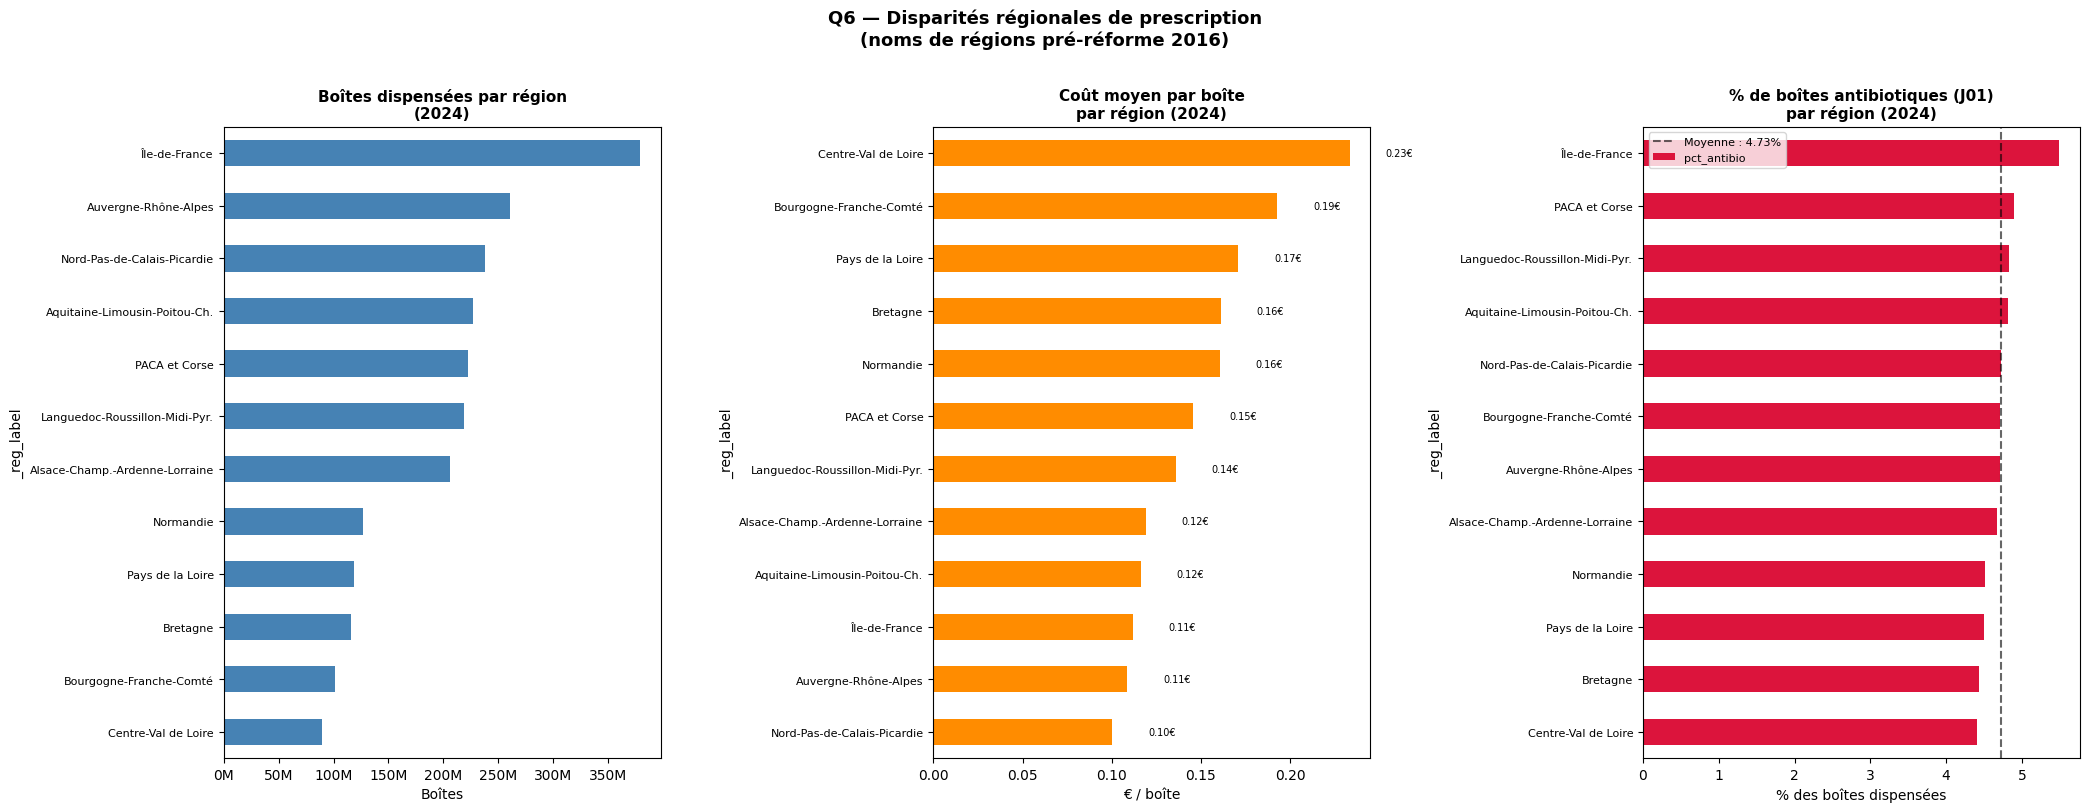

=== Q6 — Disparités régionales (2024) ===
  (Codes BEN_REG = noms pré-réforme 2016, périmètres correspondant aux nouvelles régions)

  Région                              Boîtes (M)   % vol.   Remb. (M€)    €/boîte   % Antibio.
  ----------------------------------------------------------------------------------------
  Île-de-France                             379    16.0%          42      0.11€        5.49%
  Auvergne-Rhône-Alpes                      261    11.0%          28      0.11€        4.71%
  Nord-Pas-de-Calais-Picardie               238    10.0%          24      0.10€        4.73%
  Aquitaine-Limousin-Poitou-Ch.             227     9.6%          26      0.12€        4.81%
  PACA et Corse                             222     9.4%          32      0.15€        4.90%
  Languedoc-Roussillon-Midi-Pyr.            219     9.2%          30      0.14€        4.84%
  Alsace-Champ.-Ardenne-Lorraine            206     8.7%          25      0.12€        4.67%
  Normandie                   

In [18]:
assert REG_COL, f"BEN_REG introuvable — colonnes : {list(df.columns)}"

# Codes BEN_REG — source : feuille BEN_REG du fichier descriptif-variables CNAM
# Attention : noms pré-réforme régionale 2016 (anciens périmètres)
REG_LABELS = {
    "5":  "DOM-TOM",
    "11": "Île-de-France",
    "24": "Centre-Val de Loire",
    "27": "Bourgogne-Franche-Comté",
    "28": "Normandie",
    "32": "Nord-Pas-de-Calais-Picardie",
    "44": "Alsace-Champ.-Ardenne-Lorraine",
    "52": "Pays de la Loire",
    "53": "Bretagne",
    "75": "Aquitaine-Limousin-Poitou-Ch.",
    "76": "Languedoc-Roussillon-Midi-Pyr.",
    "84": "Auvergne-Rhône-Alpes",
    "93": "PACA et Corse",
    "0":  "Inconnu",
    "99": "Inconnu",
}
df["_reg_label"] = (df[REG_COL].astype(str).str.strip()
                    .map(REG_LABELS)
                    .fillna("Code " + df[REG_COL].astype(str).str.strip()))

reg_stats = df.groupby("_reg_label").agg(
    boites        =(BOX_COL, "sum"),
    remboursement =(REM_COL, "sum"),
).dropna()
reg_stats["cout_par_boite"] = reg_stats["remboursement"] / reg_stats["boites"]
reg_stats["pct_volume"]     = reg_stats["boites"] / reg_stats["boites"].sum() * 100

# Taux d'antibiotiques (ATC2 code = J01) par région
if ATC2_CODE_COL:
    ab_mask = df[ATC2_CODE_COL].astype(str).str.upper().str.strip() == "J01"
    reg_stats["boites_antibio"] = df[ab_mask].groupby("_reg_label")[BOX_COL].sum()
    reg_stats["pct_antibio"]    = reg_stats["boites_antibio"] / reg_stats["boites"] * 100

mask_fr = ~reg_stats.index.isin(["Inconnu", "DOM-TOM"])
reg_fr  = reg_stats[mask_fr].copy()

# ── Graphiques ──
ncols = 3 if ATC2_CODE_COL else 2
fig, axes = plt.subplots(1, ncols, figsize=(7 * ncols, 8))

reg_fr.sort_values("boites")["boites"].plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title(f"Boîtes dispensées par région\n({YEAR})", fontsize=11, fontweight="bold")
axes[0].set_xlabel("Boîtes")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
axes[0].set_yticklabels([str(l)[:38] for l in reg_fr.sort_values("boites").index], fontsize=8)

reg_fr.sort_values("cout_par_boite")["cout_par_boite"].plot.barh(ax=axes[1], color="darkorange")
axes[1].set_title(f"Coût moyen par boîte\npar région ({YEAR})", fontsize=11, fontweight="bold")
axes[1].set_xlabel("€ / boîte")
axes[1].set_yticklabels([str(l)[:38] for l in reg_fr.sort_values("cout_par_boite").index], fontsize=8)
for bar, v in zip(axes[1].patches, reg_fr.sort_values("cout_par_boite")["cout_par_boite"]):
    axes[1].text(v + 0.02, bar.get_y() + bar.get_height() / 2,
                 f"{v:.2f}€", va="center", fontsize=7)

if ATC2_CODE_COL and "pct_antibio" in reg_fr.columns:
    reg_ab = reg_fr.sort_values("pct_antibio")
    reg_ab["pct_antibio"].plot.barh(ax=axes[2], color="crimson")
    mean_ab = reg_ab["pct_antibio"].mean()
    axes[2].axvline(mean_ab, color="black", linestyle="--", alpha=0.6,
                    label=f"Moyenne : {mean_ab:.2f}%")
    axes[2].set_title(f"% de boîtes antibiotiques (J01)\npar région ({YEAR})",
                      fontsize=11, fontweight="bold")
    axes[2].set_xlabel("% des boîtes dispensées")
    axes[2].legend(fontsize=8)
    axes[2].set_yticklabels([str(l)[:38] for l in reg_ab.index], fontsize=8)

plt.suptitle("Q6 — Disparités régionales de prescription\n(noms de régions pré-réforme 2016)",
             fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# ── Résultats ──
print(f"=== Q6 — Disparités régionales ({YEAR}) ===")
print(f"  (Codes BEN_REG = noms pré-réforme 2016, périmètres correspondant aux nouvelles régions)\n")
hdr = f"  {'Région':<35} {'Boîtes (M)':>10}  {'% vol.':>7}  {'Remb. (M€)':>11}  {'€/boîte':>9}"
if "pct_antibio" in reg_stats.columns:
    hdr += f"  {'% Antibio.':>11}"
print(hdr)
print(f"  {'-'*88}")
for reg, row in reg_stats.sort_values("boites", ascending=False).iterrows():
    line = (f"  {str(reg)[:33]:<35} {row['boites']/1e6:>9.0f}  {row['pct_volume']:>6.1f}%  "
            f"{row['remboursement']/1e6:>10.0f}  {row['cout_par_boite']:>8.2f}€")
    if "pct_antibio" in reg_stats.columns:
        line += f"  {row.get('pct_antibio', float('nan')):>10.2f}%"
    print(line)

if "pct_antibio" in reg_stats.columns:
    top_ab    = reg_stats[mask_fr].nlargest(1, "pct_antibio")
    bottom_ab = reg_stats[mask_fr].nsmallest(1, "pct_antibio")
    ratio     = top_ab["pct_antibio"].iloc[0] / bottom_ab["pct_antibio"].iloc[0]
    print(f"\n  Région + forte prescription antibiotique : {top_ab.index[0]} ({top_ab['pct_antibio'].iloc[0]:.2f}%)")
    print(f"  Région + faible prescription antibiotique : {bottom_ab.index[0]} ({bottom_ab['pct_antibio'].iloc[0]:.2f}%)")
    print(f"  → Rapport max / min : {ratio:.1f}x")

---
## Q7 — Polymédication et budget des seniors (60 ans et plus)

La Q3 a montré que les 60 ans et plus (code AGE=60) concentrent la majorité des boîtes dispensées.
Cette analyse va plus loin : elle quantifie le **coût unitaire** de la prescription senior
(les seniors consomment-ils des médicaments plus chers ?) et mesure la **diversité
thérapeutique** par tranche d'âge — proxy direct de la polymédication.
Elle identifie également les classes ATC qui dominent le budget des 60 ans et plus.

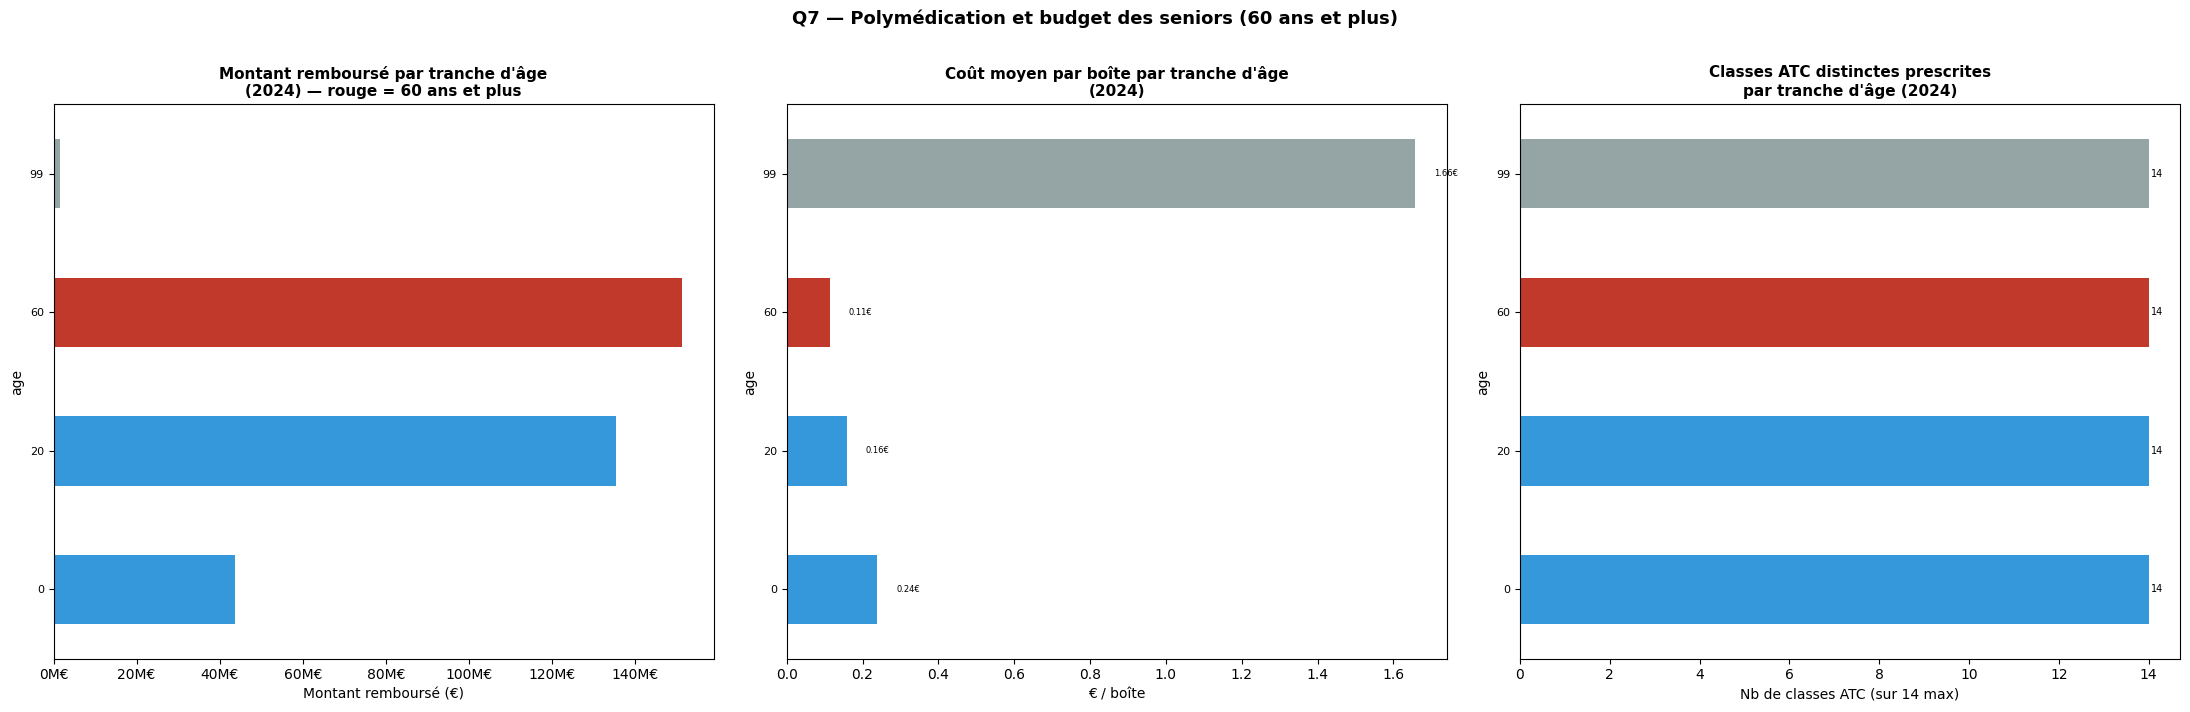

=== Q7 — Budget et polymédication seniors (2024) ===

  Seniors (60 ans et plus) :
    Boîtes dispensées  : 1328M (56.1% du total)
    Montant remboursé  : 0.15 Md€ (45.6% du total)
    Coût moyen / boîte : 0.11 €

  Non-seniors (0-59 ans) :
    Boîtes dispensées  : 1039M (43.9% du total)
    Montant remboursé  : 0.18 Md€ (54.0% du total)
    Coût moyen / boîte : 0.17 €

  → Coût unitaire seniors / non-seniors : 0.66x plus élevé

  Top 10 classes thérapeutiques chez les 60+ (triées par montant remboursé) :
  Classe ATC                                         Boîtes (M)   Remb. (M€)    €/boîte
  -----------------------------------------------------------------------------------
  SYSTEME CARDIO-VASCULAIRE                                199          45      0.23€
  SYSTEME NERVEUX                                          453          29      0.06€
  SYSTEME DIGESTIF ET METABOLISME                          259          24      0.09€
  ANTI-INFECTIEUX (USAGE SYSTEMIQUE)                    

In [19]:
def age_sort_key(label):
    m = re.search(r'\d+', str(label))
    return int(m.group()) if m else 999

# Budget et diversité thérapeutique par tranche d'âge
# Codes AGE : 0=0-19 ans, 20=20-59 ans, 60=60 ans et plus, 99=inconnu
age_budget = df.groupby(AGE_COL).agg(
    boites        =(BOX_COL, "sum"),
    remboursement =(REM_COL, "sum"),
    n_classes_atc =(ATC1_COL, "nunique"),
).dropna()
age_budget = age_budget.reindex(sorted(age_budget.index, key=age_sort_key))
age_budget["cout_par_boite"] = age_budget["remboursement"] / age_budget["boites"]

# Seuil seniors : code AGE = 60 (60 ans et plus)
df["_age_num"] = df[AGE_COL].apply(age_sort_key)
df["_senior"]  = df["_age_num"] == 60   # code 60 = 60 ans et plus
senior_boxes   = df[df["_senior"]][BOX_COL].sum()
senior_rem     = df[df["_senior"]][REM_COL].sum()
non_sen_boxes  = df[df["_age_num"].isin([0, 20])][BOX_COL].sum()
non_sen_rem    = df[df["_age_num"].isin([0, 20])][REM_COL].sum()
total_b        = df[BOX_COL].sum()
total_r        = df[REM_COL].sum()

# Top classes ATC chez les 60+
senior_atc = (df[df["_senior"]]
              .groupby(ATC1_COL).agg(
                  boites        =(BOX_COL, "sum"),
                  remboursement =(REM_COL, "sum"),
              ).dropna().sort_values("remboursement", ascending=False))

# ── Graphiques ──
# Rouge = 60+ (senior), gris = inconnu (99), bleu = <60
colors_age = ["#c0392b" if age_sort_key(a) == 60
              else "#95a5a6" if age_sort_key(a) == 99
              else "#3498db"
              for a in age_budget.index]
fig, axes  = plt.subplots(1, 3, figsize=(22, 7))

age_budget["remboursement"].plot.barh(ax=axes[0], color=colors_age)
axes[0].set_title(f"Montant remboursé par tranche d'âge\n({YEAR}) — rouge = 60 ans et plus",
                  fontsize=11, fontweight="bold")
axes[0].set_xlabel("Montant remboursé (€)")
axes[0].xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x/1e9:.1f}Md€" if x >= 1e9 else f"{x/1e6:.0f}M€"))
axes[0].set_yticklabels([str(l) for l in age_budget.index], fontsize=8)

age_budget["cout_par_boite"].plot.barh(ax=axes[1], color=colors_age)
axes[1].set_title(f"Coût moyen par boîte par tranche d'âge\n({YEAR})",
                  fontsize=11, fontweight="bold")
axes[1].set_xlabel("€ / boîte")
axes[1].set_yticklabels([str(l) for l in age_budget.index], fontsize=8)
for bar, v in zip(axes[1].patches, age_budget["cout_par_boite"]):
    axes[1].text(v + 0.05, bar.get_y() + bar.get_height() / 2,
                 f"{v:.2f}€", va="center", fontsize=6)

age_budget["n_classes_atc"].plot.barh(ax=axes[2], color=colors_age)
axes[2].set_title(f"Classes ATC distinctes prescrites\npar tranche d'âge ({YEAR})",
                  fontsize=11, fontweight="bold")
axes[2].set_xlabel("Nb de classes ATC (sur 14 max)")
axes[2].set_yticklabels([str(l) for l in age_budget.index], fontsize=8)
for bar, v in zip(axes[2].patches, age_budget["n_classes_atc"]):
    axes[2].text(v + 0.05, bar.get_y() + bar.get_height() / 2,
                 str(int(v)), va="center", fontsize=7)

plt.suptitle("Q7 — Polymédication et budget des seniors (60 ans et plus)",
             fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# ── Résultats ──
cpb_senior = senior_rem  / senior_boxes  if senior_boxes  > 0 else 0
cpb_nonsen = non_sen_rem / non_sen_boxes if non_sen_boxes > 0 else 0

print(f"=== Q7 — Budget et polymédication seniors ({YEAR}) ===\n")
print(f"  Seniors (60 ans et plus) :")
print(f"    Boîtes dispensées  : {senior_boxes/1e6:.0f}M ({senior_boxes/total_b*100:.1f}% du total)")
print(f"    Montant remboursé  : {senior_rem/1e9:.2f} Md€ ({senior_rem/total_r*100:.1f}% du total)")
print(f"    Coût moyen / boîte : {cpb_senior:.2f} €")
print(f"\n  Non-seniors (0-59 ans) :")
print(f"    Boîtes dispensées  : {non_sen_boxes/1e6:.0f}M ({non_sen_boxes/total_b*100:.1f}% du total)")
print(f"    Montant remboursé  : {non_sen_rem/1e9:.2f} Md€ ({non_sen_rem/total_r*100:.1f}% du total)")
print(f"    Coût moyen / boîte : {cpb_nonsen:.2f} €")
if cpb_nonsen > 0:
    print(f"\n  → Coût unitaire seniors / non-seniors : {cpb_senior/cpb_nonsen:.2f}x plus élevé")

print(f"\n  Top 10 classes thérapeutiques chez les 60+ (triées par montant remboursé) :")
print(f"  {'Classe ATC':<50} {'Boîtes (M)':>10}  {'Remb. (M€)':>11}  {'€/boîte':>9}")
print(f"  {'-'*83}")
for atc_n, row in senior_atc.head(10).iterrows():
    cpb = row['remboursement'] / row['boites'] if row['boites'] > 0 else 0
    print(f"  {str(atc_n)[:48]:<50} {row['boites']/1e6:>9.0f}  {row['remboursement']/1e6:>10.0f}  {cpb:>8.2f}€")

print(f"\n  Évolution du coût unitaire et de la diversité thérapeutique avec l'âge :")
print(f"  {'Tranche':<18} {'Boîtes (M)':>10}  {'Remb. (M€)':>11}  {'€/boîte':>9}  {'Nb classes ATC':>15}")
print(f"  {'-'*70}")
for age_l, row in age_budget.iterrows():
    marker = "★" if age_sort_key(age_l) == 60 else " "
    print(f"  {marker} {str(age_l):<16} {row['boites']/1e6:>9.0f}  {row['remboursement']/1e6:>10.0f}  "
          f"{row['cout_par_boite']:>8.2f}€  {int(row['n_classes_atc']):>15}")

---
## Q8 — Volume et montants remboursés par molécule (substance chimique ATC5)

La classification ATC au niveau 5 identifie la **substance chimique** — l'équivalent de la « molécule ». Agréger Open Medic à ce grain révèle deux palmarès souvent très différents : les molécules qui **dominent en volume** (médication de masse à prix unitaire bas) et celles qui **dominent en valeur** (traitements chroniques à coût unitaire élevé).

Le ratio **REM/boîte** est le principal indicateur de la valeur unitaire : une molécule peut être prescrite massivement tout en ayant un coût unitaire très faible (paracétamol), ou générer des remboursements élevés avec peu de boîtes (anticoagulants oraux directs, statines premium).

> **Limite :** la colonne `REM` est censurée pour ~35 % des lignes (effectifs insuffisants par combinaison analytique). Les molécules onéreuses prescrites à peu de patients par strate sont structurellement sous-estimées ; l'analyse volumétrique (`BOITES`) reste fiable et complète.

In [ ]:
# ── Q8 : volume et montants remboursés par molécule (substance chimique ATC5) ──
ATC5_COL = find_col(df, ["L_ATC5", "ATC5", "atc5"])

if ATC5_COL is None:
    print("⚠  Colonne ATC5 introuvable — colonnes disponibles :")
    print("  ", [c for c in df.columns if "atc" in c.lower()])
else:
    _m = df[df[ATC5_COL].notna()].copy()
    _m[BOX_COL] = pd.to_numeric(_m[BOX_COL], errors="coerce")
    _m[REM_COL] = pd.to_numeric(_m[REM_COL], errors="coerce")

    mol = (
        _m.groupby(ATC5_COL)
        .agg(boites=(BOX_COL, "sum"), rem=(REM_COL, "sum"))
        .query("boites > 0")
        .sort_values("boites", ascending=False)
    )

    n_mol = len(mol)
    top_vol = mol.head(20)
    top_rem = mol.sort_values("rem", ascending=False).head(20)

    print(f"=== Q8 — Volume et REM par molécule (ATC5) — {YEAR} ===\n")
    print(f"  Molécules distinctes (ATC5) : {n_mol:,}")
    print(f"\n  Top 5 par volume :")
    for m, r in top_vol.head(5).iterrows():
        print(f"    {str(m).title()[:45]:<47}  {r['boites']/1e6:>7.0f}M boîtes  {r['rem']/1e6:>7.1f}M€")
    print(f"\n  Top 5 par montant remboursé (REM observé) :")
    for m, r in top_rem.head(5).iterrows():
        print(f"    {str(m).title()[:45]:<47}  {r['boites']/1e6:>7.0f}M boîtes  {r['rem']/1e6:>7.1f}M€")

    # ── Fig 1 : top 20 par volume + overlay REM ──────────────────────────────
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    xs = range(len(top_vol))
    ax1.bar(xs, top_vol["boites"] / 1e6, color="#3498db", alpha=0.75, label="Boîtes (M)")
    ax2.plot(xs, top_vol["rem"] / 1e6, "o-", color="#e74c3c", lw=1.8, ms=6,
             label="REM observé (M€)")

    ax1.set_xticks(list(xs))
    ax1.set_xticklabels(
        [str(s).title()[:38] for s in top_vol.index],
        rotation=45, ha="right", fontsize=8
    )
    ax1.set_ylabel("Boîtes dispensées (millions)", color="#3498db")
    ax2.set_ylabel("Montant remboursé observé (M€)", color="#e74c3c")
    ax1.set_title(
        f"Q8 — Top 20 molécules (ATC5) par volume de prescription — {YEAR}\n"
        f"(REM partiel : ~65 % des lignes renseignées — molécules onéreuses sous-estimées)"
    )
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()

    # ── Fig 2 : top 20 par montant remboursé ─────────────────────────────────
    fig, ax = plt.subplots(figsize=(12, 6))
    ys = range(len(top_rem))
    ax.barh(list(ys), top_rem["rem"] / 1e6, color="#e74c3c", alpha=0.75)
    for i, (idx, row) in enumerate(top_rem.iterrows()):
        ax.text(
            row["rem"] / 1e6 * 1.01, i,
            f'{row["boites"]/1e6:.0f}M btes',
            va="center", fontsize=7, color="#2c3e50"
        )
    ax.set_yticks(list(ys))
    ax.set_yticklabels([str(s).title()[:45] for s in top_rem.index], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel("Montant remboursé observé (M€) — estimation partielle (~65 % des lignes)")
    ax.set_title(f"Q8 — Top 20 molécules (ATC5) par montant remboursé observé — {YEAR}")
    plt.tight_layout()
    plt.show()

    # ── Tableau récapitulatif ─────────────────────────────────────────────────
    tbl = mol.head(20).copy()
    tbl.index = [str(s).title() for s in tbl.index]
    tbl["Boîtes (M)"]       = (tbl["boites"] / 1e6).round(1)
    tbl["REM observé (M€)"] = (tbl["rem"] / 1e6).round(1)
    tbl["REM/boîte (€)"]    = (tbl["rem"] / tbl["boites"]).round(2)
    display(tbl[["Boîtes (M)", "REM observé (M€)", "REM/boîte (€)"]])